# [Classical Guitar Intonation and Compensation](https://github.com/beausol/classical-guitar)

This Jupyter Notebook generates all plots and tables shown in
"Classical Guitar Intonation and Compensation: The Well-Tempered Guitar,"
by Matt Anderson and Ray Beausoleil.

Required Python packages to use the CGIC package include:
* NumPy
* pandas
* matplotlib
* SciPy (for optimize.curve_fit and optimize.minimize)
* IPython
* rich
* sys and os

Additional packages required for this notebook are:
* SymPy
* sklearn

In [84]:
import pkgutil

# Check that all required packages are installed
pkg_list = [ 'numpy', 'pandas', 'matplotlib', 'scipy', 'IPython', 'rich', 'sys', 'os',
             'sympy', 'sklearn' ]
for pkg in pkg_list:
    if pkgutil.find_loader(pkg) is None:
        print("{} is not installed".format(pkg))
    else:
        print("{} is installed".format(pkg))

numpy is installed

pandas is installed

matplotlib is installed

scipy is installed

IPython is installed

rich is installed

sys is installed

os is installed

sympy is installed

sklearn is installed

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import matplotlib.ticker as ticker
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sym
import pandas as pd
from scipy.optimize import curve_fit, minimize
from IPython.display import display, Math
from sklearn.utils import Bunch
from rich import print
import guitar.cgic as cg

# Define a reasonable set of matplotlib parameters compatible
#  with Jupyter notebooks
linewidth = 2
linestyles = [':', '--', '-', '-.']
labelsize = 18
fontsize = 24
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : fontsize,
        }
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,amsfonts}')

gitpath = 'C:/vcs/git/docs/classical-guitar'

def rms(dnu):
    return np.sqrt(np.mean(dnu**2))

def savefig(pathname, filename):
    savepath = cg.file_path(pathname, filename)
    if savepath is None:
        pass
    else:
        plt.savefig(savepath, bbox_inches='tight')
        print("\nSaved {0}\n".format(savepath))

## Tests of Approximations

In [6]:
save_fig_dir = gitpath + '/cgic/figures/'

def set_globals():
    global scale_length, b, c, d
    global ds_0, dn_0, ds, dn
    global r, kappa, rho, b_0

    scale_length = 650.0
    b = 1.0
    c = 4.0
    d = 10

    ds_0 = 0.0
    dn_0 = 0.0
    ds = 1.8
    dn = -0.38

    r = 25
    kappa = 2*r + 1
    rho = 0.43
    b_0 = np.sqrt(kappa) * rho / (2 * scale_length)

max_fret = 12
fret_list = np.arange(1, max_fret + 1)

def gamma(n):
    return 2.0**(n/12.0)

def dsdn(x0, b, c, d, kappa, b0, fret_list):
    def sigma_k(fret_list, k):
        return np.sum((gamma(fret_list) - 1)**k)

    def optfunc(dsdn):
        ds = dsdn[0]
        dn = dsdn[1]
        return rms( tfe(scale_length, ds, dn, b, c, d, kappa, rho, fret_list) )

    mnu = ( mde(x0, 0, 0, b, c, d, fret_list)
           - (1200/np.log(2)) * ( gamma(fret_list)**2 * (b + c)**2 - c**2 ) / (2 * x0**2) )
    tnu = tse(x0, 0, 0, b, c, d, kappa, fret_list)
    bnu = bse(x0, 0, 0, b, c, d, kappa, rho, fret_list)

    z_n = (np.log(2.0) / 1200.0) * ( mnu + tnu + bnu )

    sigma_0 = max_fret
    sigma_1 = sigma_k(fret_list, 1)
    sigma_2 = sigma_k(fret_list, 2)

    zbar_0 = np.sum(z_n)
    zbar_1 = np.sum((gamma(fret_list) - 1) * z_n)
        
    det = sigma_0 * sigma_2 - sigma_1**2
    dsc =  ( sigma_0 * zbar_1 - sigma_1 * zbar_0 ) * x0 / det
    dnc = -( sigma_2 * zbar_0 - sigma_1 * zbar_1 ) * x0 / det
    
    x0 = [dsc, dnc]

    res = minimize(optfunc, x0)
    dsm = res.x[0]
    dnm = res.x[1]
    
    return (dsc, dnc, dsm, dnm)

def dsdnx(x0, b, c, d, kappa, b0, fret_list):
    fret_d = kappa * 2 * (2*b + c)**2 * d / scale_length**2
    dsx = b0 * scale_length + kappa * ( (b + c)**2 - 7 * b**2 ) / (4 * scale_length) - fret_d
    dnx = -kappa * b * (5 * b + c)/(2 * scale_length) - fret_d

    return (dsx, dnx)

### Logarithmic Frequency Separation

In [8]:
def delta_nu(f_1, f_2):
    return 1200 * np.log2(f_2 / f_1)

def delta_nux1(f_1, f_2):
    f = (f_1 + f_2) / 2
    df = f_2 - f_1
    return (1200 / np.log(2)) * (df / f)

def delta_nux2(f_1, f_2):
    f = f_1
    df = f_2 - f_1
    return (1200 / np.log(2)) * (df / f)

f_start = 220.0 # Hz (A_3)
f_stop = 440.0 + 30  # Hz (A_4 plus a smidge)
npts = 201
f_1 = f_start
f_2 = np.linspace(f_start, f_stop, npts, endpoint=True)

dnu = delta_nu(f_1, f_2)
dnu_ax1 = delta_nux1(f_1, f_2)
dnu_ax2 = delta_nux2(f_1, f_2)

plt.figure(figsize=(8.0,6.0))
plt.plot(f_2 - f_1, dnu, linewidth=linewidth, label='exact')
plt.plot(f_2 - f_1, dnu_ax1, '-.', linewidth=linewidth, label=r'$f = (f_1 + f_2)/2$')
plt.plot(f_2 - f_1, dnu_ax2, '--', linewidth=linewidth, label=r'$f = f_1$')
plt.xlabel(r'$f_2 - f_1$ (Hz)', fontdict=font)
plt.ylabel(r'$\Delta \nu$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(0, 250)
plt.ylim(0, 2000)
plt.legend(loc='upper left', fontsize=labelsize)
plt.grid(True)
savefig(save_fig_dir, 'diff_pitch.pdf')
plt.show()

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/diff_pitch.pdf

### $L_0$

The unfretted length of the guitar is given by
\begin{equation}
  L_0 = \sqrt{\left(X_0 + \Delta S + \Delta N\right)^2 + c^2}\, .
\end{equation}

In [11]:
X_0, c = sym.symbols("X_0 c", positive=True)
S, N, epsilon = sym.symbols("S N epsilon", real=True)
def L_0(X_0, S, N, c):
    return sym.sqrt( (X_0 + S + N)**2 + c**2 )
display(L_0(X_0, S, N, c))
display(sym.series( L_0(X_0, epsilon * S, epsilon * N, epsilon * c), x=epsilon, n=3 ))
display(sym.simplify(sym.series( L_0(X_0, epsilon * S, epsilon * N, epsilon * c), x=epsilon, n=3 )))

sqrt(c**2 + (N + S + X_0)**2)

X_0 + X_0*epsilon*(N/X_0 + S/X_0) + X_0*epsilon**2*((N/X_0 + S/X_0)**2/2 - (2*N/X_0 + 2*S/X_0)**2/8 + c**2/(2*X_0**2)) + O(epsilon**3)

c**2*epsilon**2/(2*X_0) + X_0 + S*epsilon + N*epsilon + O(epsilon**3)

Since $\Delta S$, $\Delta N$, and $c$ are all small compared to $X_0$,
\begin{equation}
  L_0 \approx X_0 + \Delta S + \Delta N + \frac{c^2}{2\, X_0}\, .
\end{equation}

In [13]:
def l0(x0, ds, dn, c):
    length = np.sqrt( (x0 + ds + dn)**2 + c**2 )
    return length

def l0x(x0, ds, dn, c):
    length = x0 + ds + dn + c**2 / (2 * x0)
    return length

### $L_n$

The resonant length of a string clamped to the $n^\textrm{th}$ fret is
\begin{equation}
  L_n = \sqrt{\left(X_n + \Delta S\right)^2 + (b + c)^2}\, .
\end{equation}

In [16]:
X_n, b, c = sym.symbols("X_n b c", positive=True)
S, epsilon = sym.symbols("S epsilon", real=True)
def L_n(X_n, S, b, c):
    return sym.sqrt( (X_n + S)**2 + (b + c)**2 )
display(L_n(X_n, S, b, c))
display(sym.simplify(sym.series( L_n(X_n, epsilon * S, epsilon * b, epsilon * c), x=epsilon, n=3 )))

sqrt((S + X_n)**2 + (b + c)**2)

epsilon**2*(b + c)**2/(2*X_n) + X_n + S*epsilon + O(epsilon**3)

Since $\Delta S$, $b$, and $c$ are all small compared to $X_n = X_0 / \gamma_n$,
\begin{equation}
  L_n \approx X_n + \Delta S + \frac{(b + c)^2}{2\, X_n}\, .
\end{equation}

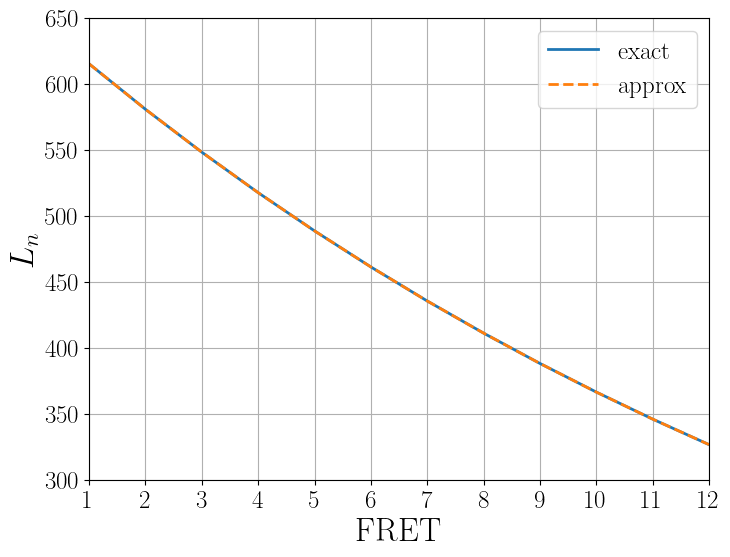

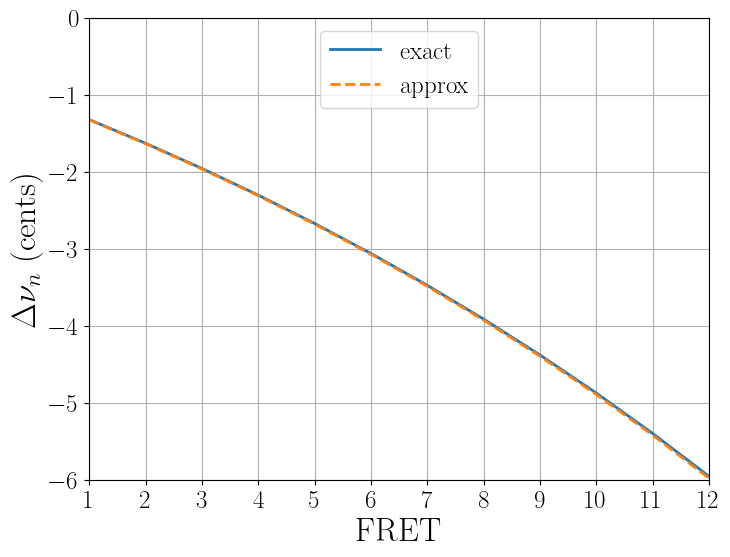

In [18]:
set_globals()

def l(x0, ds, b, c, fret_list):
    length = np.sqrt( (x0/gamma(fret_list) + ds)**2 + (b + c)**2 )
    return length

def lx(x0, ds, b, c, fret_list):
    length = x0/gamma(fret_list) + ds + gamma(fret_list) * (b + c)**2 / (2 * x0) 
    return length

def rle(x0, ds, dn, b, c, fret_list):
    dnu = 1200 * np.log2( l0(x0, ds, dn, c) / (gamma(fret_list) * l(x0, ds, b, c, fret_list)) )
    return dnu

def rlex(x0, ds, dn, b, c, fret_list):
    dnu = ( 1200 / np.log(2) ) * ( (dn - (gamma(fret_list) - 1) * ds) / x0 )
    dnu -= ( 1200 / np.log(2) ) * ( gamma(fret_list)**2 * (b + c)**2 - c**2 ) / ( 2 * x0**2 )
    return dnu

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, l(scale_length, ds, b, c, fret_list), linewidth=linewidth, label='exact')
plt.plot(fret_list, lx(scale_length, ds, b, c, fret_list), '--', linewidth=linewidth, label='approx')
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$L_n$', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(300,650)
plt.legend(loc='upper right', fontsize=labelsize)
plt.grid(True)
#savefig(save_fig_dir, 'ln_test.pdf')
plt.show()

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, rle(scale_length, ds, dn, b, c, fret_list), '-', linewidth=linewidth, label=r'exact')
plt.plot(fret_list, rlex(scale_length, ds, dn, b, c, fret_list), '--', linewidth=linewidth, label=r'approx')
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu_n$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(-6.0,0.0)
plt.legend(loc='upper center', fontsize=labelsize)
plt.grid(True)
#savefig(save_fig_dir, 'rlnu_test.pdf')
plt.show()

### $L_n^\prime$

When $d \ne 0$,
\begin{equation}
  L_n^\prime = \frac{L_n}{X_n + \Delta S}\, d + \sqrt{ \left(X_0 - X_n + \Delta N - d\right)^2 + \left(b + \frac{b + c}{X_n + \Delta S}\, d\right)^2 }\, .
\end{equation}
Unfortunately, SymPy is not up to the task of expanding $L_n^\prime$ in a Taylor series of small distances because (at the time of this writing) it isn't possible to inform $\texttt{sympy.simplify}$ that $X_n < X_0$. Relying on Mathematica, we find
\begin{equation}
  L_n^\prime \approx X_0 - X_n + \Delta N + \frac{b^2}{2\left(X_0 - X_n\right)} + \frac{\left[(b + c)\, X_0 - c\, X_n\right] d - b^2\, \Delta N\, X_n^2}{2\, X_n^2 \left(X_0 - X_n\right)^2}
\end{equation}

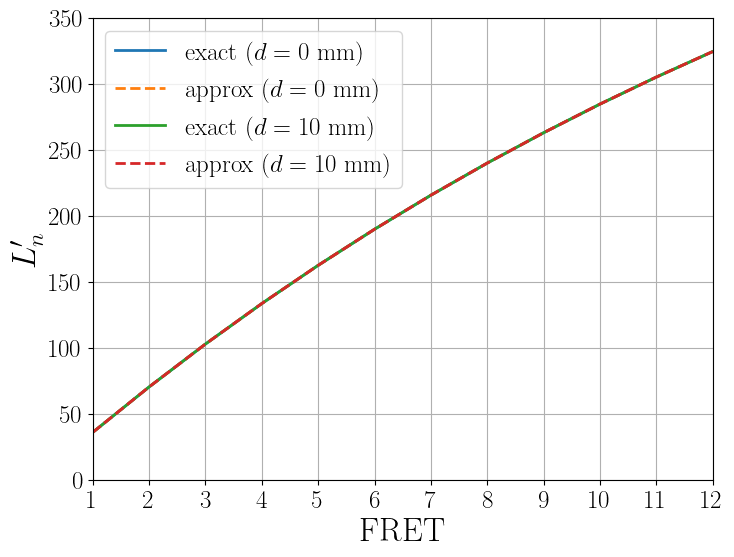

In [21]:
set_globals()

def lp(x0, ds, dn, b, c, d, fret_list):
    xn = x0 / gamma(fret_list)
    length = ( l(x0, ds, b, c, fret_list) / (xn + ds)  ) * d
    length += np.sqrt( (x0 - xn + dn - d)**2
                     + (b + (b + c) * d / (xn + ds))**2 )
    return length

def lpx(x0, ds, dn, b, c, d, fret_list):
    xn = x0 / gamma(fret_list)
    length = x0 - xn + dn + b**2 / ( 2 * (x0 - xn) )
    length += ( (((b + c) * x0 - c * xn)**2 * d - b**2 * dn * xn**2) / (2 * (x0 - xn)**2 * xn**2) )
    return length

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, lp(scale_length, ds, dn, b, c, 0.0, fret_list), linewidth=linewidth, label=r'exact ($d = 0$~mm)')
plt.plot(fret_list, lpx(scale_length, ds, dn, b, c, 0.0, fret_list), '--', linewidth=linewidth, label=r'approx ($d = 0$~mm)')
plt.plot(fret_list, lp(scale_length, ds, dn, b, c, d, fret_list), linewidth=linewidth, label=r'exact ($d = {}$~mm)'.format(d))
plt.plot(fret_list, lpx(scale_length, ds, dn, b, c, d, fret_list), '--', linewidth=linewidth, label=r'approx ($d = {}$~mm)'.format(d))
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$L_n^\prime$', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(0,350)
plt.legend(loc='upper left', fontsize=labelsize)
plt.grid(True)
#savefig(save_fig_dir, 'lnp_test.pdf')
plt.show()

### $Q_n$

In our paper, we follow Byers and define the relative displacement
\begin{equation}
  Q_n \equiv \frac{\mathcal{L}_n - L_0}{L_0}\, ,
\end{equation}
where $\mathcal{L}_n \equiv L_n + L_n^\prime$. Again, we can't use SymPy to expand $Q_n$ in a Taylor series, but from Mathematica we find
\begin{equation}
  Q_n \approx \frac{\left[ \gamma_n\, b + (\gamma_n - 1)\, c \right]^2}{2\, (\gamma_n - 1)\, X_0^2} \left( 1 + \frac{\gamma_n^2}{\gamma_n - 1}\, \frac{d}{X_0} \right)\, ,
\end{equation}
We also can determine a second-order in $d$ correction, but it isn't worth the trouble because it only matters at the first fret.

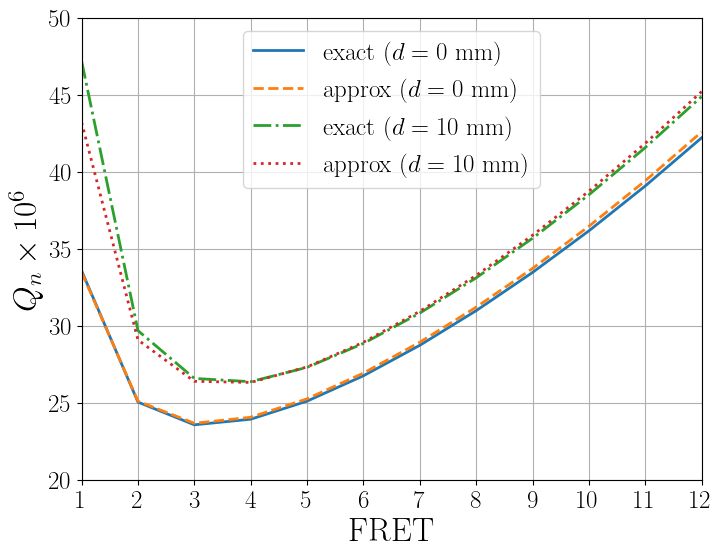

In [24]:
set_globals()

def lmc(x0, ds, dn, b, c, d, fret_list):
    length = l(x0, ds, b, c, fret_list) + lp(x0, ds, dn, b, c, d, fret_list)
    return length

def lmcx(x0, ds, dn, b, c, fret_list):
    length = lx(x0, ds, b, c, fret_list) + lpx(x0, ds, dn, b, c, d, fret_list)
    return length

def q(x0, ds, dn, b, c, d, fret_list):
    qn = ( lmc(x0, ds, dn, b, c, d, fret_list) - l0(x0, ds, dn, c) ) / l0(x0, ds, dn, c)
    return qn

def qx(x0, b, c, d, fret_list):
    gn = gamma(fret_list)
    qn = ( (( (gn - 1) / (2 * x0**2) ) * ( gn * b / (gn - 1) + c )**2)
         * (1 + (gn**2 / (gn - 1)) * d / x0 ) )
    return qn

def mde(x0, ds, dn, b, c, d, fret_list):
    dnu = 600 * np.log2( 1 + q(x0, ds, dn, b, c, d, fret_list) )
    return dnu

def mdex(x0, b, c, d, fret_list):
    dnu = (600 / np.log(2)) * qx(x0, b, c, d, fret_list)
    return dnu

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, 1.0e+06*q(scale_length, ds, dn, b, c, 0.0, fret_list),
         '-', linewidth=linewidth, label=r'exact ($d = 0$~mm)')
plt.plot(fret_list, 1.0e+06*qx(scale_length, b, c, 0.0, fret_list), '--', linewidth=linewidth, label=r'approx ($d = 0$~mm)')
plt.plot(fret_list, 1.0e+06*q(scale_length, ds, dn, b, c, d, fret_list), 
         '-.', linewidth=linewidth, label=r'exact ($d = {}$~mm)'.format(d))
plt.plot(fret_list, 1.0e+06*qx(scale_length, b, c, d, fret_list),
         ':', linewidth=linewidth, label=r'approx ($d = {}$~mm)'.format(d))
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$Q_n \times 10^6$', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(20,50)
plt.legend(loc='upper center', fontsize=labelsize)
plt.grid(True)
#savefig(save_fig_dir, 'qn_test.pdf')
plt.show()

### Tension ($T_n$)

Given $Q_n$, it is straightforward to determine the corresponding frequency error due to the slight increase in tension due to fretting. We have
\begin{equation}
  \Delta \nu_n = 600\, \log_2 \left( 1 + \kappa\, Q_n \right) \approx \frac{600}{\ln(2)}\, \kappa\, Q_n\, .
\end{equation}
Let's compare these exact and approximate equations, using the approximation for $Q_n$ given above.

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/tnu_test.pdf

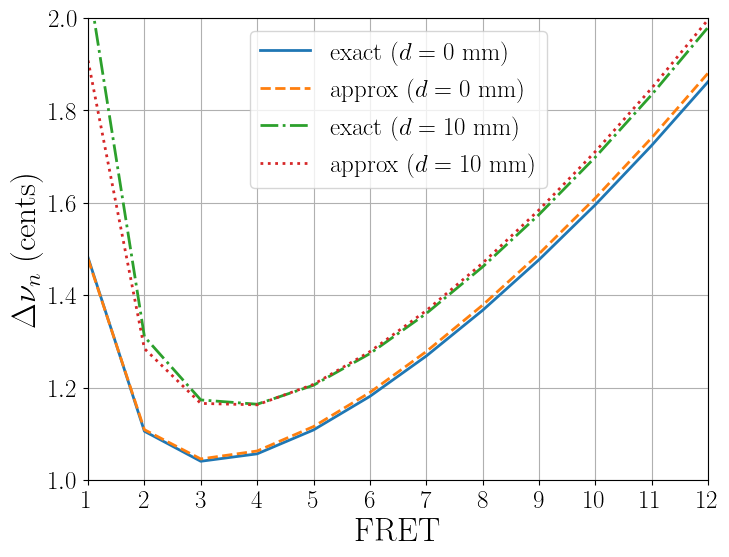

In [27]:
set_globals()

def tse(x0, ds, dn, b, c, d, kappa, fret_list):
    dnu = 600 * np.log2( 1 + kappa * q(x0, ds, dn, b, c, d, fret_list) )
    return dnu

def tsex(x0, b, c, d, kappa, fret_list):
    dnu = (600 / np.log(2)) * kappa * qx(x0, b, c, d, fret_list)
    return dnu

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, tse(scale_length, ds, dn, b, c, 0.0, kappa, fret_list), '-', linewidth=linewidth, label=r'exact ($d = 0$~mm)')
plt.plot(fret_list, tsex(scale_length, b, c, 0.0, kappa, fret_list), '--', linewidth=linewidth, label=r'approx ($d = 0$~mm)')
plt.plot(fret_list, tse(scale_length, ds, dn, b, c, d, kappa, fret_list), '-.', linewidth=linewidth, label=r'exact ($d = {}$~mm)'.format(d))
plt.plot(fret_list, tsex(scale_length, b, c, d, kappa, fret_list), ':', linewidth=linewidth, label=r'approx ($d = {}$~mm)'.format(d))
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu_n$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(1.0,2.0)
plt.legend(loc='upper center', fontsize=labelsize)
plt.grid(True)
savefig(save_fig_dir, 'tnu_test.pdf')
plt.show()

### Bending Stiffness ($B_n$)

The frequency shift due to bending stiffness is
\begin{equation}
  \Delta \nu = 1200\, \log_2 \left[ \frac{1 + B_n + (1 + \pi^2/2)\, B_n^2}{1 + B_0 + (1 + \pi^2/2)\, B_0^2} \right]\, .
\end{equation}

In [30]:
gamma_n, B_n, B_0 = sym.symbols("gamma_n B_n B_0", positive=True)
def dnu(gamma_n, B_0):
    B_n = gamma_n * B_0
    return sym.log( (1 + B_n + (1 + sym.pi**2/2) * B_n**2)
                  / (1 + B_0 + (1 + sym.pi**2/2) * B_0**2) )
display(dnu(gamma_n, B_0))
display(sym.simplify(sym.series( dnu(gamma_n, B_0), x=B_0, n=3 )))

log((B_0**2*gamma_n**2*(1 + pi**2/2) + B_0*gamma_n + 1)/(B_0**2*(1 + pi**2/2) + B_0 + 1))

B_0*(gamma_n - 1) + B_0**2*(2*gamma_n**2 + pi**2*gamma_n**2 - 2*gamma_n - (gamma_n - 1)**2 - pi**2)/2 + O(B_0**3)

In [31]:
display(sym.simplify(2 * (gamma_n**2 - gamma_n) - (gamma_n - 1)**2))
display(sym.simplify(2 * (gamma_n**2 - gamma_n) - (gamma_n - 1)**2 + gamma_n**2 * sym.pi**2 - sym.pi**2))
display(sym.factor(2 * (gamma_n**2 - gamma_n) - (gamma_n - 1)**2 + gamma_n**2 * sym.pi**2 - sym.pi**2))

gamma_n**2 - 1

gamma_n**2 + pi**2*gamma_n**2 - pi**2 - 1

(1 + pi**2)*(gamma_n - 1)*(gamma_n + 1)

Sad. Anyway, you get the idea:
\begin{equation}
  \Delta \nu \approx \frac{1200}{\ln(2)}\, \left[ \left(\gamma_n - 1\right) B_0 + \frac{1}{2}\, \left(\gamma_n^2 - 1\right) \left(1 + \pi^2\right) B_0^2 \right]\, .
\end{equation}

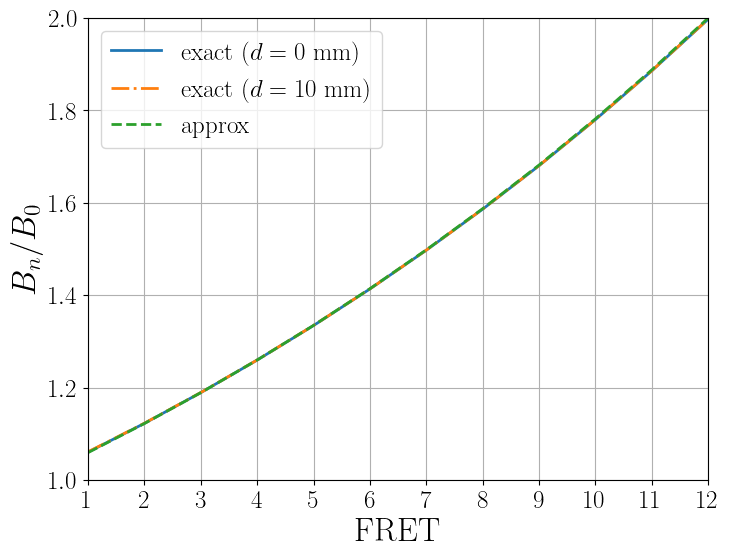

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/bnu_test.pdf

In [33]:
set_globals()

def bn(x0, ds, dn, b, c, d, kappa, fret_list):
    l_0 = l0(x0, ds, dn, c)
    l_n = l(x0, ds, b, c, fret_list)
    stiff = np.sqrt( 1 + kappa * q(x0, ds, dn, b, c, d, fret_list)  ) * l_0 / l_n
    return stiff
    
def bnx(fretlist):
    return gamma(fret_list)

def bse(x0, ds, dn, b, c, d, kappa, rho, fret_list):
    b_0 = np.sqrt(kappa) * rho / (2 * l0(x0, ds, dn, c))
    b_n = bn(x0, ds, dn, b, c, d, kappa, fret_list) * b_0
    dnu = 1200 * np.log2( (1 + b_n + (1 + np.pi**2/2) * b_n**2) / (1 + b_0 + (1 + np.pi**2/2) * b_0**2) )
    return dnu

def bsex(x0, ds, dn, c, kappa, rho, fret_list):
    b_0 = np.sqrt(kappa) * rho / (2 * x0)
    dnu = (1200 / np.log(2)) * (gamma(fret_list) - 1) * b_0
    return dnu

def bsex2(x0, ds, dn, c, kappa, rho, fret_list):
    gn = gamma(fret_list)
    b_0 = np.sqrt(kappa) * rho / (2 * x0)
    dnu = (1200 / np.log(2)) * ( (gn - 1) * b_0 + 0.5 * (gn**2 - 1) * (1 + np.pi**2) * b_0**2 )
    return dnu

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, bn(scale_length, ds, dn, b, c, 0.0, 2 * kappa, fret_list), '-', linewidth=linewidth, label=r'exact ($d = 0$~mm)')
plt.plot(fret_list, bn(scale_length, ds, dn, b, c, d, 2 * kappa, fret_list), '-.', linewidth=linewidth, label=r'exact ($d = {}$~mm)'.format(d))
plt.plot(fret_list, bnx(fret_list), '--', linewidth=linewidth, label='approx')
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$B_n / B_0$', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(1.0,2.0)
plt.legend(loc='upper left', fontsize=labelsize)
plt.grid(True)
#savefig(save_fig_dir, 'bn_test.pdf')
plt.show()

plt.figure(figsize=(8.0,6.0))
plt.plot(fret_list, bse(scale_length, ds, dn, b, c, 0.0, kappa, rho, fret_list), '-',  linewidth=linewidth, label='exact')
plt.plot(fret_list, bsex2(scale_length, ds, dn, c, kappa, rho, fret_list), '-.',
         linewidth=linewidth, label=r'approx (2$^\mathrm{nd}$ order)')
plt.plot(fret_list, bsex(scale_length, ds, dn, c, kappa, rho, fret_list), '--',
         linewidth=linewidth, label=r'approx (1$^\mathrm{st}$ order)')
plt.xlabel('FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu_n$~(cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(1,12)
plt.xticks(fret_list)
plt.ylim(0.0,5.0)
plt.legend(loc='upper left', fontsize=labelsize)
plt.grid(True)
savefig(save_fig_dir, 'bnu_test.pdf')
plt.show()

### Total Frequency Error

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/uncomp.pdf

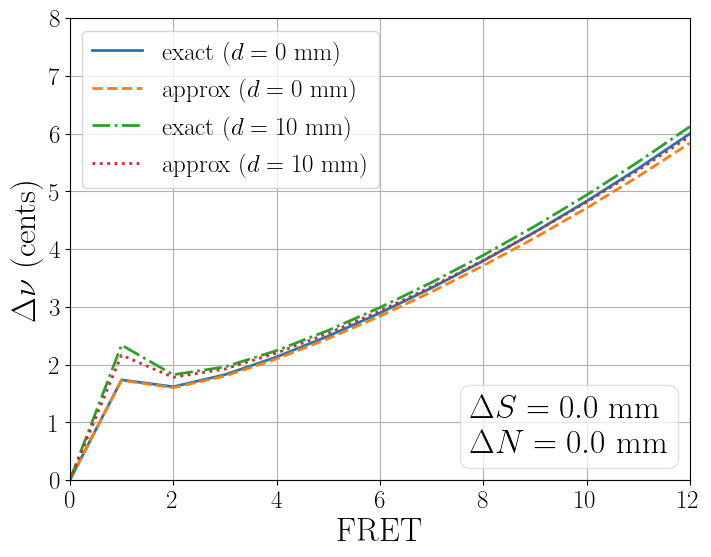

In [35]:
def tfe(x0, ds, dn, b, c, d, kappa, rho, fret_list):
    rnu = rle(x0, ds, dn, b, c, fret_list)
    mnu = mde(x0, ds, dn, b, c, d, fret_list)
    tnu = tse(x0, ds, dn, b, c, d, kappa, fret_list)
    bnu = bse(x0, ds, dn, b, c, d, kappa, rho, fret_list)
    
    return rnu + mnu + tnu + bnu

def tfex(x0, ds, dn, b, c, d, kappa, rho, fret_list):
    rnu = rlex(x0, ds, dn, b, c, fret_list)
    mnu = mdex(x0, b, c, d, fret_list)
    tnu = tsex(x0, b, c, d, kappa, fret_list)
    bnu = bsex(x0, ds, dn, c, kappa, rho, fret_list)
    
    return rnu + mnu + tnu + bnu

fig = plt.figure(figsize=(8.0,6.0))
ax = fig.add_subplot(111)
shifts0 = tfe(scale_length, ds_0, dn_0, b, c, 0, kappa, rho, fret_list)
shiftx0 = tfex(scale_length, ds_0, dn_0, b, c, 0, kappa, rho, fret_list)
shifts1 = tfe(scale_length, ds_0, dn_0, b, c, d, kappa, rho, fret_list)
shiftx1 = tfex(scale_length, ds_0, dn_0, b, c, d, kappa, rho, fret_list)
plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts0, 0, 0), '-', linewidth=linewidth, label=r'exact ($d = 0$~mm)')
plt.plot(np.insert(fret_list, 0, 0), np.insert(shiftx0, 0, 0), '--', linewidth=linewidth, label=r'approx ($d = 0$~mm)')
plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts1, 0, 0), '-.', linewidth=linewidth, label=r'exact ($d = {}$~mm)'.format(d))
plt.plot(np.insert(fret_list, 0, 0), np.insert(shiftx1, 0, 0), ':', linewidth=linewidth, label=r'approx ($d = {}$~mm)'.format(d))
plt.xlabel(r'FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(0,fret_list[-1])
plt.ylim(0.0,8.0)
plt.grid(True)
annotation = ( r'$\Delta S = {:.{prec}} \mathrm{{~mm}}$'.format(ds_0, prec=2) + '\n'
             + r'$\Delta N = {:.{prec}} \mathrm{{~mm}}$'.format(dn_0, prec=2) )
ob = offsetbox.AnchoredText(annotation, loc='lower right', pad=0, borderpad=0.65, prop=dict(size=fontsize))
ob.patch.set(boxstyle='round', edgecolor='#D7D7D7', facecolor='white', alpha=0.75)
ax.add_artist(ob)
plt.legend(loc='upper left', fontsize=labelsize)
savefig(save_fig_dir, 'uncomp.pdf')
plt.show()

### Compensation

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/comp_dn.pdf

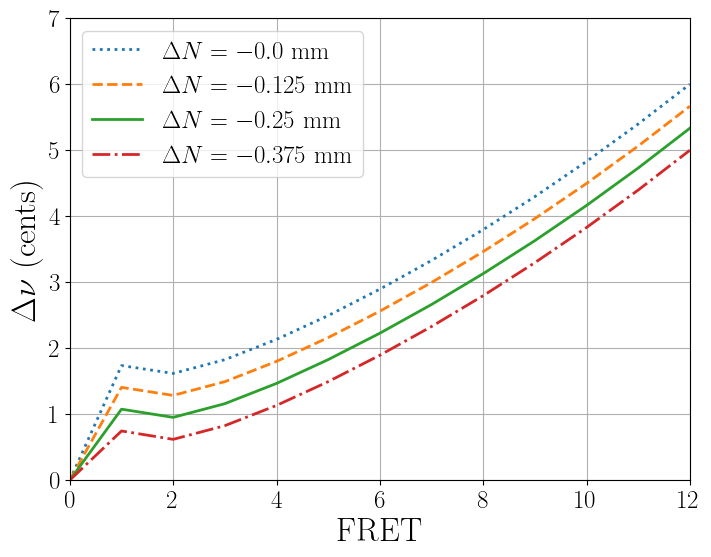

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/comp_ds.pdf

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
ds = 0.0
dn_list = -np.array([0.0, 0.125, 0.250, 0.375])
plt.figure(figsize=(8.0,6.0))
for dn, linestyle in zip(dn_list, linestyles):
    shifts = tfe(scale_length, ds, dn, b, c, 0, kappa, rho, fret_list)
    plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts, 0, 0), linestyle, linewidth=linewidth,
             label=r'$\Delta N = {}$ mm'.format(dn))
plt.xlabel(r'FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(0,fret_list[-1])
plt.ylim(0,7)
plt.grid(True)
plt.legend(loc='upper left', fontsize=labelsize)
savefig(save_fig_dir, 'comp_dn.pdf')
plt.show()

ds_list = np.array([0.0, 1.0, 2.0, 3.0])
dn = 0.0
plt.figure(figsize=(8.0,6.0))
for ds, linestyle in zip(ds_list, linestyles):
    shifts = tfe(scale_length, ds, dn, b, c, 0, kappa, rho, fret_list)
    plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts, 0, 0), linestyle, linewidth=linewidth,
             label=r'$\Delta S = {}$ mm'.format(ds))
plt.xlabel(r'FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(0,fret_list[-1])
plt.ylim(-2,7)
plt.grid(True)
plt.legend(loc='upper left', fontsize=labelsize)
savefig(save_fig_dir, 'comp_ds.pdf')
plt.show()

d_00 = 0.0
d_10 = 10.0

b_0 = np.sqrt(kappa) * rho / (2 * scale_length)
dsx_00, dnx_00 = dsdnx(scale_length, b, c, d_00, kappa, b_0, fret_list)
dsc_00, dnc_00, dsm_00, dnm_00 = dsdn(scale_length, b, c, d_00, kappa, b_0, fret_list)

display(Math(r'$\kappa = {}; B_0 = {:.{prec}}$'.format(kappa, b_0, prec=3)))

display(Math(r'$d = {}\mathrm{{~mm}}$'.format(d_00)))
display(Math(r'$\Delta S = {:.{prec}}\mathrm{{~mm~(approx)}}; \Delta N = {:.{prec}}\mathrm{{~mm~(approx)}}'.format(dsx_00, dnx_00, prec=3)))
display(Math(r'$\Delta S = {:.{prec}} \mathrm{{~mm~(fit)}}; \Delta N = {:.{prec}} \mathrm{{~mm~(fit)}}'.format(dsc_00, dnc_00, prec=3)))
display(Math(r'$\Delta S = {:.{prec}} \mathrm{{~mm~(min)}}; \Delta N = {:.{prec}} \mathrm{{~mm~(min)}}'.format(dsm_00, dnm_00, prec=3)))

dsx_10, dnx_10 = dsdnx(scale_length, b, c, d_10, kappa, b_0, fret_list)
dsc_10, dnc_10, dsm_10, dnm_10 = dsdn(scale_length, b, c, d_10, kappa, b_0, fret_list)

display(Math(r'$d = {}\mathrm{{~mm}}$'.format(d_10)))
display(Math(r'$\Delta S = {:.{prec}}\mathrm{{~mm~(approx)}}; \Delta N = {:.{prec}}\mathrm{{~mm~(approx)}}'.format(dsx_10, dnx_10, prec=3)))
display(Math(r'$\Delta S = {:.{prec}} \mathrm{{~mm~(fit)}}; \Delta N = {:.{prec}} \mathrm{{~mm~(fit)}}'.format(dsc_10, dnc_10, prec=3)))
display(Math(r'$\Delta S = {:.{prec}} \mathrm{{~mm~(min)}}; \Delta N = {:.{prec}} \mathrm{{~mm~(min)}}'.format(dsm_10, dnm_10, prec=3)))

plt.figure(figsize=(8.0,6.0))
shifts0 = tfe(scale_length, dsm_00, dnm_00, b, c, d_00, kappa, rho, fret_list)
shiftx0 = tfe(scale_length, dsx_00, dnx_00, b, c, d_00, kappa, rho, fret_list)
shifts1 = tfe(scale_length, dsm_10, dnm_10, b, c, d_10, kappa, rho, fret_list)
shiftx1 = tfe(scale_length, dsx_10, dnx_10, b, c, d_10, kappa, rho, fret_list)
plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts0, 0, 0), '-', linewidth=linewidth, label=r'$d = 0$~mm (min)')
plt.plot(np.insert(fret_list, 0, 0), np.insert(shiftx0, 0, 0), '--', linewidth=linewidth, label=r'$d = 0$~mm (approx)')
plt.plot(np.insert(fret_list, 0, 0), np.insert(shifts1, 0, 0), '-.', linewidth=linewidth, label=r'$d = {}$~mm (min)'.format(d))
plt.plot(np.insert(fret_list, 0, 0), np.insert(shiftx1, 0, 0), ':', linewidth=linewidth, label=r'$d = {}$~mm (approx)'.format(d))
plt.xlabel(r'FRET', fontdict=font)
plt.ylabel(r'$\Delta \nu$ (cents)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(0,fret_list[-1])
plt.ylim(-0.4,1.0)
plt.grid(True)
plt.legend(loc='upper right', fontsize=labelsize)
plt.show()

# Fit String Data

In [39]:
def build_string_file_names(sheet_name):
    strings = sheet_name.lower()
    
    save_specs_name = 'tbl_' + strings + '_specs.tex'
    save_props_name = 'tbl_' + strings + '_props.tex'
    save_fit_name = 'fit_' + strings + '.pdf'

    return (save_specs_name, save_props_name, save_fit_name)

def fit_strings(scale_length, scale_dx,
                strings_name, sheet_name, sigma_name, markersize=12.5):
    # Define object and files names
    save_specs_name, save_props_name, save_fit_name = build_string_file_names(sheet_name)

    # Load the string specifications
    strings = cg.GuitarStrings(strings_name, path_guitar_strings_specs, None,
                               scale_length=scale_length, sheet_name=sheet_name)
    strings.save_specs_table(show=show, savepath=save_tbl_dir, filename=save_specs_name)
    
    # Determine $R$ for each string from data
    strings.fit_r(path_guitar_strings_data,
                  sheet_name=sheet_name, sigma_name=sigma_name, scale_dx=scale_dx,
                  show=show, save_path=save_fig_dir, file_name=save_fit_name)
    strings.save_props_table(show=show, savepath=save_tbl_dir, filename=save_props_name)
    strings.save_props_excel(filepath=path_guitar_strings_props, sheet_name=sheet_name)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej43_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej43.pdf

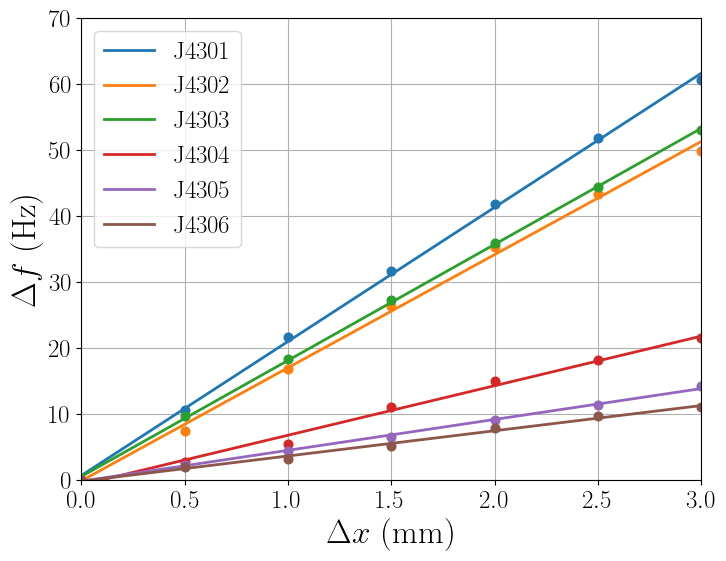

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej43_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ43)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej45.pdf

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ45)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej46.pdf

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ46)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej44_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej44.pdf

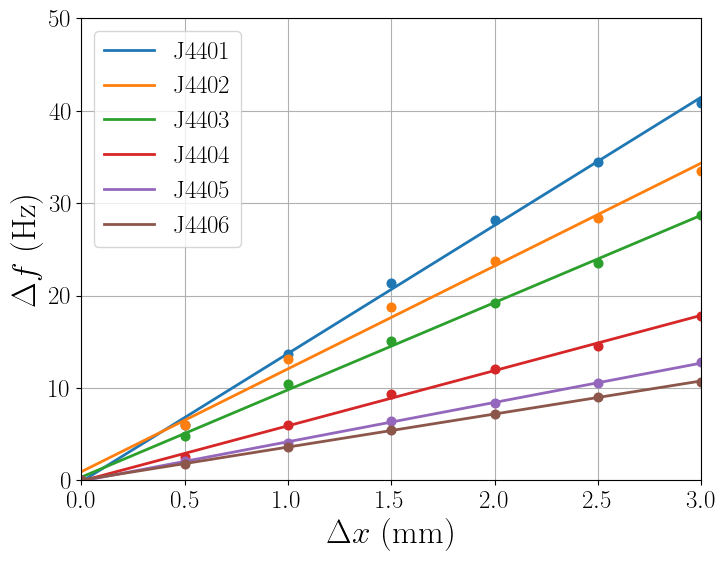

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej44_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ44)

D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45ff_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej45ff.pdf

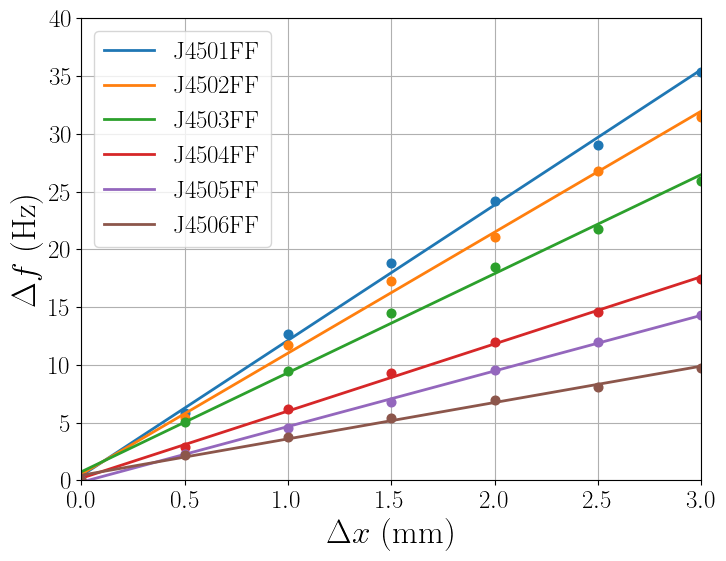

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45ff_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ45FF)

D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46ff_specs.tex

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ej46ff.pdf

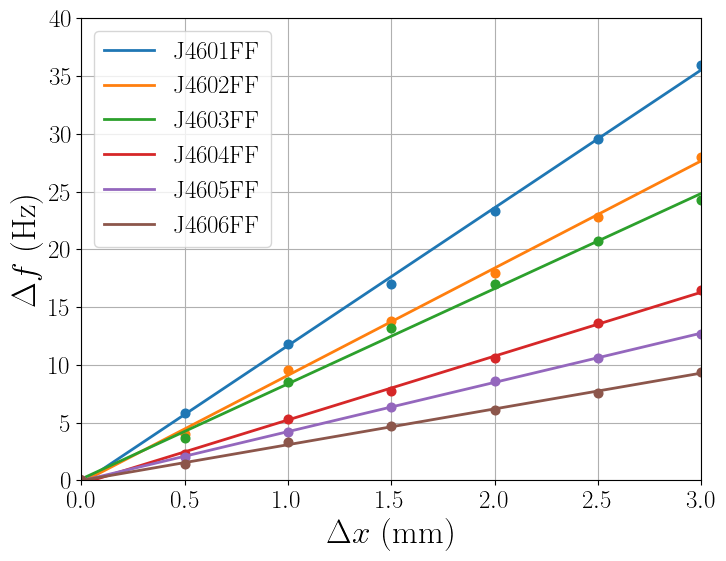

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46ff_props.tex

Saved C:/vcs/git/docs/classical-guitar/data/guitar_strings_props.xlsx (EJ46FF)

In [40]:
strings_names = [ "D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)"
                ]
sheet_names = [ 'EJ43', 'EJ45', 'EJ46', 'EJ44', 'EJ45FF', 'EJ46FF' ]
sigma_names = [ None, 'EJ45eb', None, None, None, None ]

scale_length = 650.0 # mm
scale_dx = 2**(1/12) # dx measured at first fret
path_guitar_strings_specs = gitpath + '/data/guitar_strings_specs.xlsx'
path_guitar_strings_data = gitpath + '/data/guitar_strings_data.xlsx'
path_guitar_strings_props = gitpath + '/data/guitar_strings_props.xlsx'
save_fig_dir = gitpath + '/cgic/figures/'
save_tbl_dir = gitpath + '/cgic/files/'
show = True

for strings_name, sheet_name, sigma_name in zip(strings_names, sheet_names, sigma_names):
    print('\n[bold magenta]' + strings_name + '[/bold magenta]\n')    
    
    fit_strings(scale_length, scale_dx, strings_name, sheet_name, sigma_name)

# Classical Guitar Compensation

In [42]:
def build_guitar_file_names(guitar_name, sheet_name):
    strings = sheet_name.lower()
    
    save_setbacks_name = 'tbl_' + strings + '_setbacks.tex'

    guitar = ''.join(guitar_name.lower().split())
    guitar_plus_strings = guitar + '_' + strings

    save_comp_null_name = 'shift_' + guitar_plus_strings + '_null.pdf'
    save_comp_harm_name = 'shift_' + guitar_plus_strings + '_harmonic.pdf'
    save_comp_full_name = 'shift_' + guitar_plus_strings + '_full.pdf'
    save_comp_mean_name = 'shift_' + guitar_plus_strings + '_mean.pdf'

    return (save_setbacks_name, save_comp_null_name, save_comp_harm_name,
            save_comp_full_name, save_comp_mean_name)

def init_setbacks(string_count:int):
    setbacks = Bunch(
        rho = np.zeros(string_count),
        r = np.zeros(string_count),
        dsx = np.zeros(string_count),
        dsc = np.zeros(string_count),
        dsm = np.zeros(string_count),
        dnx = np.zeros(string_count),
        dnc = np.zeros(string_count),
        dnm = np.zeros(string_count),
        rmu = np.zeros([0,]),
        rmx = np.zeros([0,]),
        rmc = np.zeros([0,]),
        rmm = np.zeros([0,]) )
    
    return setbacks

def compensate(strings_name, sheet_name, setbacks, markersize=12.5):
    # Define object and files names
    save_setbacks_name, save_comp_null_name, save_comp_harm_name, \
    save_comp_full_name, save_comp_mean_name \
    = build_guitar_file_names(guitar_name, sheet_name)

     # Load the string specifications and properties
    strings = cg.GuitarStrings(strings_name, path_guitar_strings_specs, path_guitar_strings_props,
                               sheet_name=sheet_name, scale_length=scale_length)
    rho = strings.get_specs().radius.to_numpy()
    r = strings.get_props().r.to_numpy()
    
    # Test compensation strategies
    params['name'] = guitar_name + ' + ' + sheet_name
    params['ds'] = 0.0
    params['dn'] = 0.0
    guitar = cg.Guitar(params, string_count, strings)
    if show:
        print(guitar)
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : Uncompensated [/magenta]\n')
    rmu = guitar.plot_shifts(show=show, savepath=save_fig_dir, filename=save_comp_null_name, markersize=9.0)
    
    dsx, dnx = guitar.approximate()
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : Approximate [/magenta]\n')
    rmx = guitar.plot_shifts(show=show, savepath=None, filename=None)
    dsc, dnc = guitar.compensate(max_fret)
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : RMS Fit [/magenta]\n')
    rmc = guitar.plot_shifts(show=show, savepath=None, filename=None)
    dsm, dnm = guitar.minimize(max_fret)
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : BFGS Minimize [/magenta]\n')
    rmm = guitar.plot_shifts(show=show, savepath=save_fig_dir, filename=save_comp_full_name)
    guitar.save_setbacks_table(show=show, savepath=save_tbl_dir, filename=save_setbacks_name)

    guitar.set_params({'ds' : [np.round(np.mean(dsm), 2)], 'dn' : [np.round(np.mean(dnm), 2)]})
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : BFGS Minimize Mean [/magenta]\n')
    guitar.plot_shifts(show=show, savepath=save_fig_dir, filename=save_comp_mean_name)
    print('\n[magenta]' + guitar_name + ' + ' + sheet_name + ' : BFGS Minimize Mean Harmonic [/magenta]\n')
    guitar.plot_shifts(harm=[[2, 3], [5, 9]], show=show, savepath=save_fig_dir, filename=save_comp_harm_name)
    
    setbacks.rho = np.vstack((setbacks.rho, rho))
    setbacks.r = np.vstack((setbacks.r, r))
    setbacks.dsx = np.vstack((setbacks.dsx, dsx))
    setbacks.dsc = np.vstack((setbacks.dsc, dsc))
    setbacks.dsm = np.vstack((setbacks.dsm, dsm))
    setbacks.dnx = np.vstack((setbacks.dnx, dnx))
    setbacks.dnc = np.vstack((setbacks.dnc, dnc))
    setbacks.dnm = np.vstack((setbacks.dnm, dnm))
    setbacks.rmu = np.append(setbacks.rmu, rmu)
    setbacks.rmx = np.append(setbacks.rmx, rmx)
    setbacks.rmc = np.append(setbacks.rmc, rmc)
    setbacks.rmm = np.append(setbacks.rmm, rmm)
    
    return setbacks, strings

def errors(x, y):
    err = x - y

    idx_max = np.argmax(np.abs(err))
    max_mm = err[idx_max]
    max_pc = 100 * max_mm / y[idx_max]

    rms_mm = rms(err)
    rms_pc = 100 * rms_mm / rms(y)

    return max_mm, max_pc, rms_mm, rms_pc

def multistring(setbacks):
    def func(x, intercept, slope):
        return intercept + slope * x

    # Delete light-tension nylon string set
    rho_data = setbacks.rho[2:].flatten()
    r_data = setbacks.r[2:].flatten()
    dsx_data = setbacks.dsx[2:].flatten()
    dsc_data = setbacks.dsc[2:].flatten()
    dsm_data = setbacks.dsm[2:].flatten()
    dnx_data = setbacks.dnx[2:].flatten()
    dnc_data = setbacks.dnc[2:].flatten()
    dnm_data = setbacks.dnm[2:].flatten()

    param, param_cov = curve_fit(func, rho_data, dsm_data)
    fit = func(rho_data, *param)

    rho_mean = np.mean(rho_data)
    rho_std = np.std(rho_data)

    r_mean = np.mean(r_data)
    r_std = np.std(r_data)
    
    dsx_mean = np.mean(dsx_data)
    dsx_std = np.std(dsx_data)
    dsc_mean = np.mean(dsc_data)
    dsc_std = np.std(dsc_data)
    dsm_mean = np.mean(dsm_data)
    dsm_std = np.std(dsm_data)
    
    dnx_mean = np.mean(dnx_data)
    dnx_std = np.std(dnx_data)
    dnc_mean = np.mean(dnc_data)
    dnc_std = np.std(dnc_data)
    dnm_mean = np.mean(dnm_data)
    dnm_std = np.std(dnm_data)
    
    rms = np.vstack((setbacks.rmu, setbacks.rmx, setbacks.rmc, setbacks.rmm,
                     setbacks.rmu / setbacks.rmx, setbacks.rmu / setbacks.rmc, setbacks.rmu / setbacks.rmm,
                     100 * (setbacks.rmx - setbacks.rmm) / setbacks.rmm,
                     100 * (setbacks.rmc - setbacks.rmm) / setbacks.rmm))
    df = pd.DataFrame(rms, columns=sheet_names,
                      index=['Uncompensated', 'Approximate', 'RMS Fit', 'RMS Minimize',
                             'Uncomp/Approx', 'Uncomp/Fit', 'Uncomp/Min',
                             'Approx - Min (%)', 'Fit - Min (%)'])
    print('\n')
    display(Math(r'$\textbf{{String Set RMS Frequency Errors}}$'))
    display(df)
    
    print('\n')
    display(Math(r'$\textbf{{Mean Setbacks}}$'))
    display(Math(r'$\overline{{\Delta S}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(Approximate)}}$'.format(dsx_mean, dsx_std)))
    display(Math(r'$\overline{{\Delta S}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(RMS Fit)}}$'.format(dsc_mean, dsc_std)))
    display(Math(r'$\overline{{\Delta S}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(RMS Minimize)}}$'.format(dsm_mean, dsm_std)))
    display(Math(r'$\overline{{\Delta N}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(Approximate)}}$'.format(dnx_mean, dnx_std)))
    display(Math(r'$\overline{{\Delta N}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(RMS Fit)}}$'.format(dnc_mean, dnc_std)))
    display(Math(r'$\overline{{\Delta N}} = {:.2} \pm {:.1} \mathrm{{~mm}} \quad \textrm{{(RMS Minimize)}}$'.format(dnm_mean, dnm_std)))
    
    print('\n')
    display(Math(r'$\textbf{{Saddle Setback Fit}}$'))
    display(Math(r'$\overline{{R}} = {} \pm {}$'.format(round(r_mean), round(r_std))))
    display(Math(r'$\overline{{\rho}} = {:.2} \pm {:.2} \mathrm{{~mm}}$'.format(rho_mean, rho_std)))
    display(Math(r'$\Delta S = ({:.1} \pm {:.1}) + ({:.2} \pm {:.1})\, \rho \quad \textrm{{(RMS Minimize)}}$'.format(param[0], np.sqrt(param_cov[0,0]), param[1], np.sqrt(param_cov[1,1]))))
    
    print('\n')
    if show:
        fig = plt.figure(figsize=(8.0,6.0))
        ax = fig.add_subplot(111)
        plt.hist(r_data, bins=np.linspace(20,32,13))
        plt.xlabel(r'$R$', fontdict=font)
        plt.ylabel('NUMBER OF STRINGS', fontdict=font)
        plt.tick_params(axis='x', labelsize=labelsize)
        plt.tick_params(axis='y', labelsize=labelsize)
        plt.locator_params(axis='y', integer=True)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2)) 
        plt.xlim(20, 32)
        plt.ylim(cg.get_ylim())
        plt.grid(True)
        annotation = r'$\overline{{R}} = {} \pm {}$'.format(round(r_mean), round(r_std))
        ob = offsetbox.AnchoredText(annotation, loc='upper right', pad=0, borderpad=0.65, prop=dict(size=fontsize))
        ob.patch.set(boxstyle='round', edgecolor='#D7D7D7', facecolor='white', alpha=0.75)
        ax.add_artist(ob)
        savefig(save_fig_dir, 'hist_r.pdf')
        plt.show()

        fig = plt.figure(figsize=(8.0,6.0))
        ax = fig.add_subplot(111)
        plt.plot(rho_data, dsm_data, '.', markersize=12.5)
        plt.plot(rho_data, fit, linewidth=linewidth)
        plt.xlabel(r'$\rho$ (mm)', fontdict=font)
        plt.ylabel(r'$\Delta S$ (mm)', fontdict=font)
        plt.tick_params(axis='x', labelsize=labelsize)
        plt.tick_params(axis='y', labelsize=labelsize)
        plt.xlim(0.3, 0.6)
        plt.ylim(1.2,2.6)
        plt.grid(True)
        annotation_1 = r'$\Delta S = ({:.2} \pm {:.1})\, \rho$'.format(param[1], np.sqrt(param_cov[1,1]))
        ob_1 = offsetbox.AnchoredText(annotation_1, loc='upper left', pad=0, borderpad=0.65, prop=dict(size=fontsize))
        ob_1.patch.set(boxstyle='round', edgecolor='#D7D7D7', facecolor='white', alpha=0.75)
        ax.add_artist(ob_1)
        annotation_2 = r'$\overline{{\rho}} = {:.2} \pm {:.2} \mathrm{{~mm}}$'.format(rho_mean, rho_std) + '\n' + r'$\overline{{\Delta S}} = {:.2} \pm {:.1} \mathrm{{~mm}}$'.format(dsm_mean, dsm_std)
        ob_2 = offsetbox.AnchoredText(annotation_2, loc='lower right', pad=0, borderpad=0.65, prop=dict(size=fontsize))
        ob_2.patch.set(boxstyle='round', edgecolor='#D7D7D7', facecolor='white', alpha=0.75)
        ax.add_artist(ob_2)
        savefig(save_fig_dir, 'fit_ds.pdf')
        plt.show()

        fig = plt.figure(figsize=(8.0,6.0))
        ax = fig.add_subplot(111)
        plt.hist(-dnm_data, 21)
        plt.xlabel(r'$-\Delta N$ (mm)', fontdict=font)
        plt.ylabel('NUMBER OF STRINGS', fontdict=font)
        plt.tick_params(axis='x', labelsize=labelsize)
        plt.tick_params(axis='y', labelsize=labelsize)
        plt.locator_params(axis='y', integer=True)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.02)) 
        plt.xlim(cg.get_xlim())
        plt.ylim(cg.get_ylim())
        plt.grid(True)
        annotation = r'$\overline{{\Delta N}} = -{:.2} \pm {:.1} \mathrm{{~mm}}$'.format(-dnm_mean, dnm_std)
        ob = offsetbox.AnchoredText(annotation, loc='upper right', pad=0, borderpad=0.65, prop=dict(size=fontsize))
        ob.patch.set(boxstyle='round', edgecolor='#D7D7D7', facecolor='white', alpha=0.75)
        ax.add_artist(ob)
        savefig(save_fig_dir, 'hist_dn.pdf')
        plt.show()

## Classical Guitar ($d = 0$ mm)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)

Classical Guitar + EJ43 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4301  E_4     0.349         0.361          66.4   
J4302  B_3     0.403         0.487          50.2   
J4303  G_3     0.504         0.808          52.5   
J4304  D_3     0.356         1.822          66.4   
J4305  A_2     0.419         2.741          56.0   
J4306  E_2     0.533         5.158          59.2   
String  R   R std kappa    B_0   E_eff (GPa)
J4301  37.8  0.5   76.6  0.00235    13.28   
J4302  42.6  1.0   86.2  0.00287     8.50   
J4303  55.0  0.4  111.1  0.00409     7.30   
J4304  31.4  1.2   63.7  0.00218    10.65   
J4305  26.1  0.5   53.2  0.00235     5.40   
J4306  28.5  1.1   57.9  0.00312     3.83   

Classical Guitar + EJ43 : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej43_null.pdf

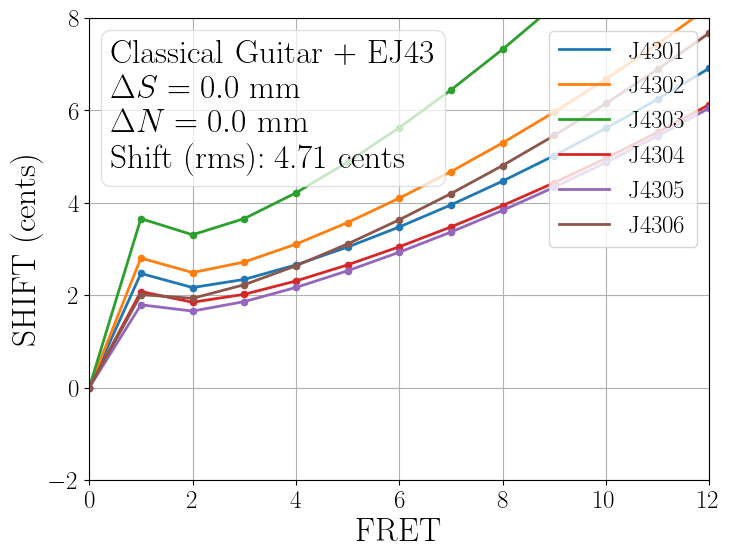

Classical Guitar + EJ43 : Approximate 

Classical Guitar + EJ43 : RMS Fit 

Classical Guitar + EJ43 : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej43_full.pdf

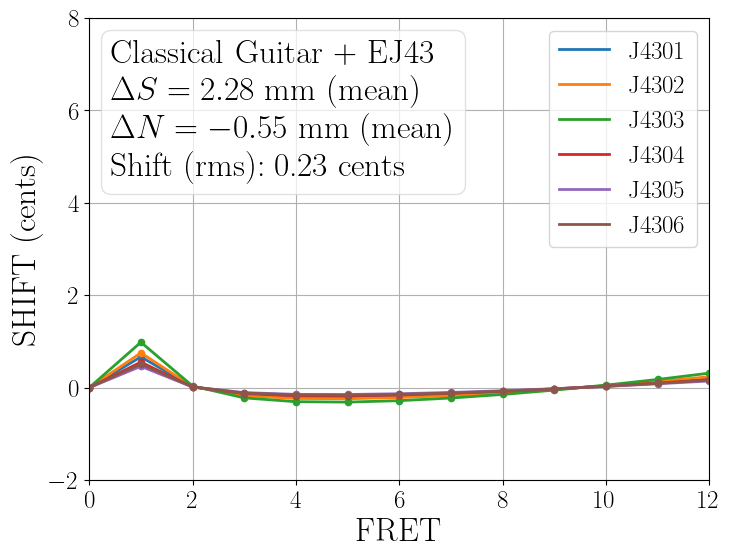

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej43_setbacks.tex

Classical Guitar + EJ43 : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej43_mean.pdf

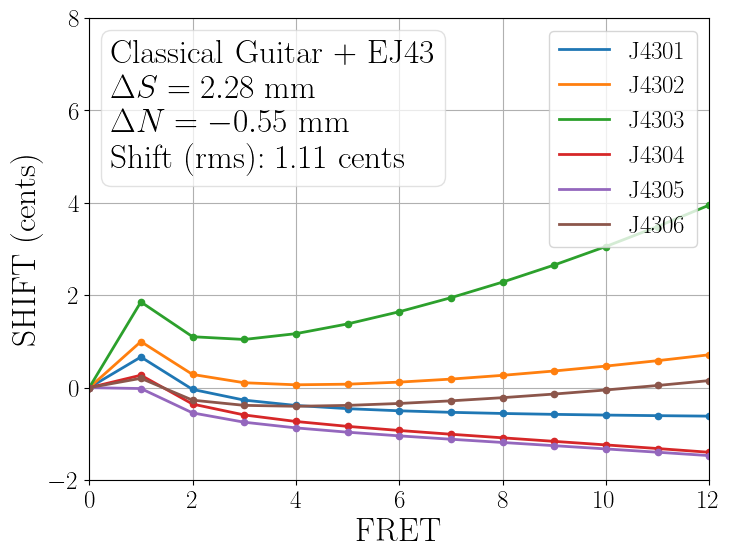

Classical Guitar + EJ43 : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej43_harmonic.pdf

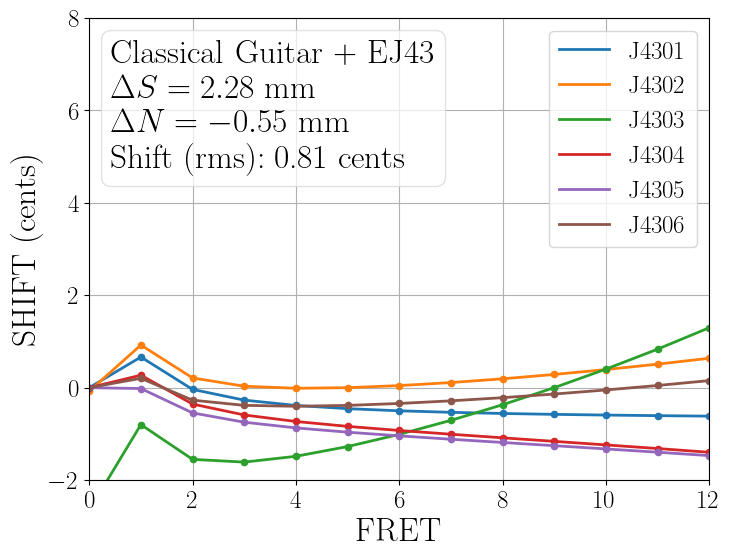

D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)

Classical Guitar + EJ45 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4501  E_4     0.356         0.374          68.6   
J4502  B_3     0.409         0.505          52.0   
J4503  G_3     0.512         0.836          54.2   
J4504  D_3     0.368         1.920          70.0   
J4505  A_2     0.445         3.289          67.3   
J4506  E_2     0.546         5.470          62.8   
String  R   R std kappa    B_0   E_eff (GPa)
J4501  23.6  0.5   48.2  0.00190     8.33   
J4502  23.8  0.7   48.7  0.00220     4.82   
J4503  28.8  0.6   58.6  0.00301     3.87   
J4504  22.5  0.8   46.0  0.00192     7.56   
J4505  23.9  0.7   48.7  0.00239     5.28   
J4506  28.6  0.4   58.2  0.00321     3.90   

Classical Guitar + EJ45 : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45_null.pdf

Classical Guitar + EJ45 : Approximate 

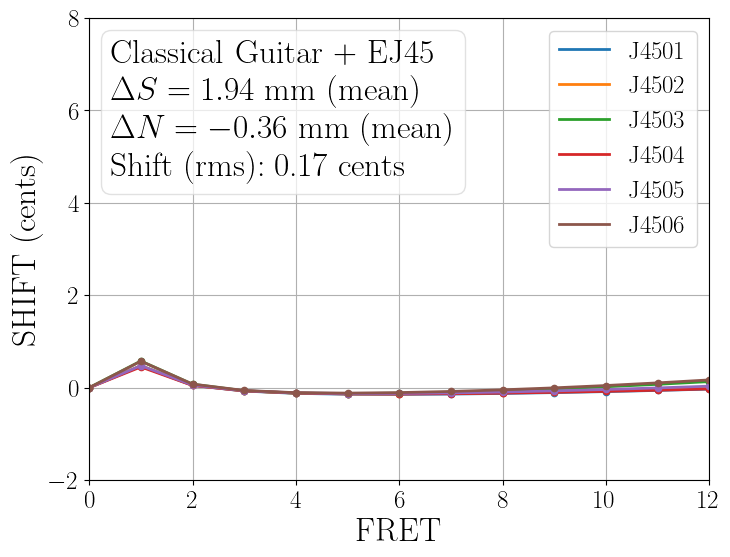

Classical Guitar + EJ45 : RMS Fit 

Classical Guitar + EJ45 : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45_full.pdf

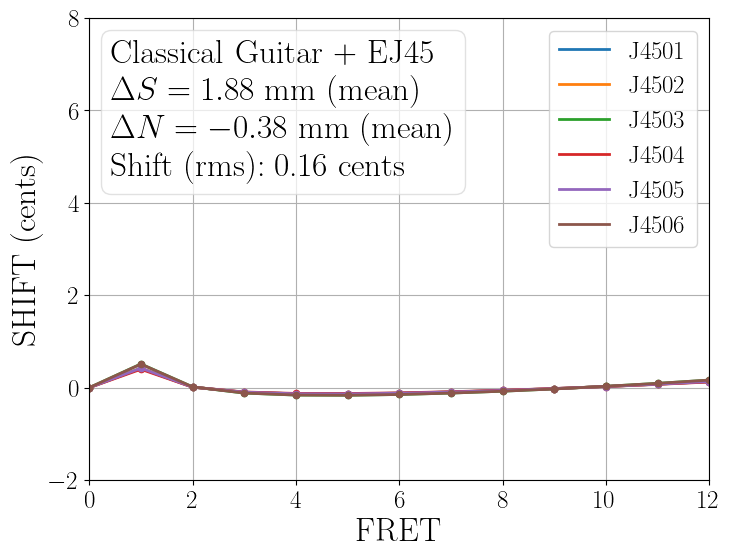

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45_setbacks.tex

Classical Guitar + EJ45 : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45_mean.pdf

Classical Guitar + EJ45 : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45_harmonic.pdf

D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)

Classical Guitar + EJ46 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4601  E_4     0.362         0.386          70.9   
J4602  B_3     0.415         0.522          53.8   
J4603  G_3     0.521         0.856          55.6   
J4604  D_3     0.381         2.007          73.1   
J4605  A_2     0.457         3.486          71.3   
J4606  E_2     0.559         5.666          65.0   
String  R   R std kappa    B_0   E_eff (GPa)
J4601  23.5  0.5   47.9  0.00193     8.25   
J4602  26.2  0.3   53.5  0.00234     5.31   
J4603  28.3  1.0   57.5  0.00304     3.75   
J4604  22.7  0.3   46.4  0.00200     7.43   
J4605  24.0  0.2   49.0  0.00246     5.32   
J4606  25.5  0.3   51.9  0.00310     3.44   

Classical Guitar + EJ46 : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46_null.pdf

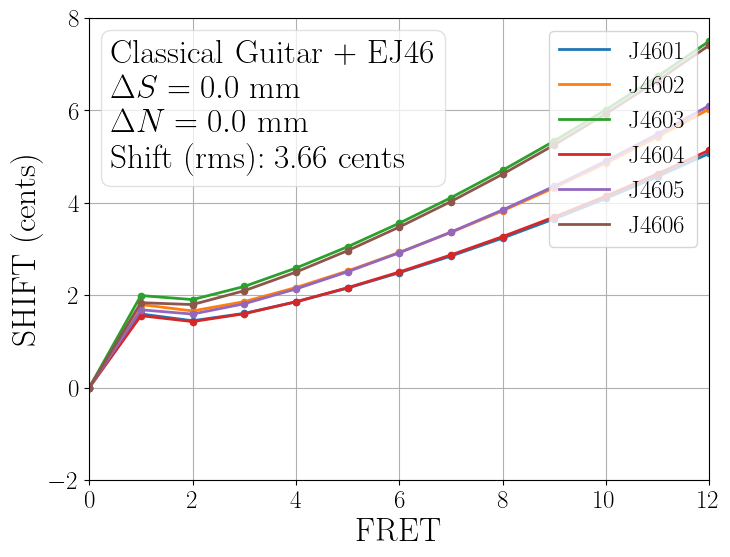

Classical Guitar + EJ46 : Approximate 

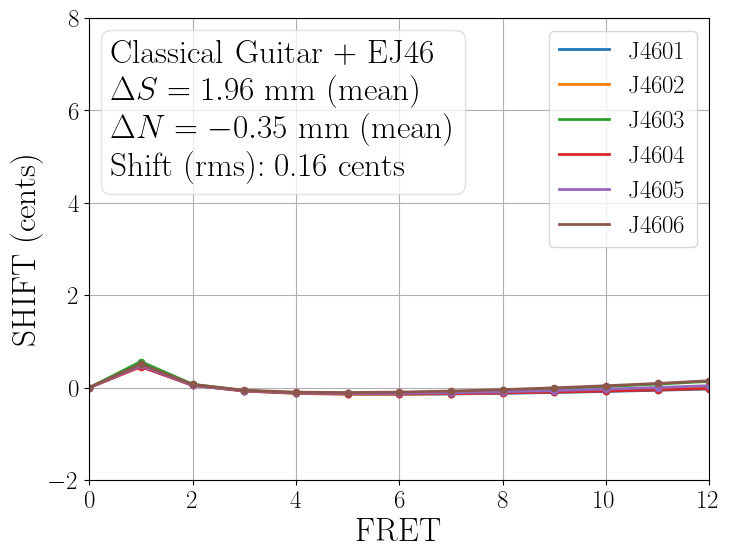

Classical Guitar + EJ46 : RMS Fit 

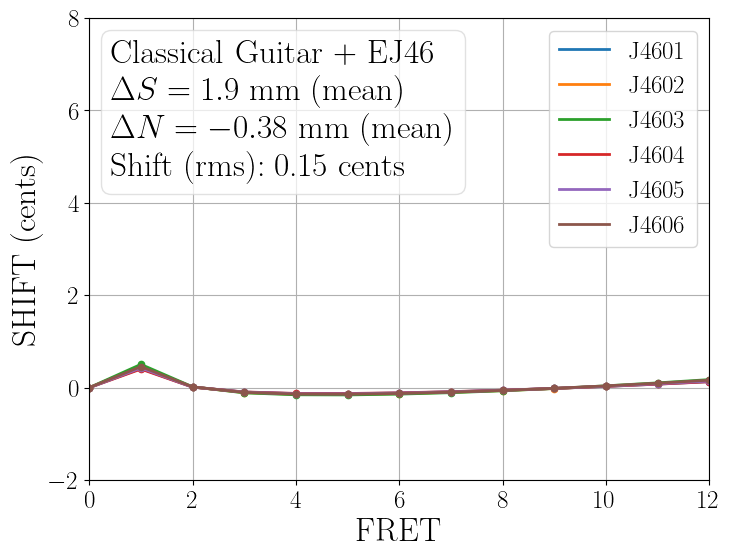

Classical Guitar + EJ46 : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46_full.pdf

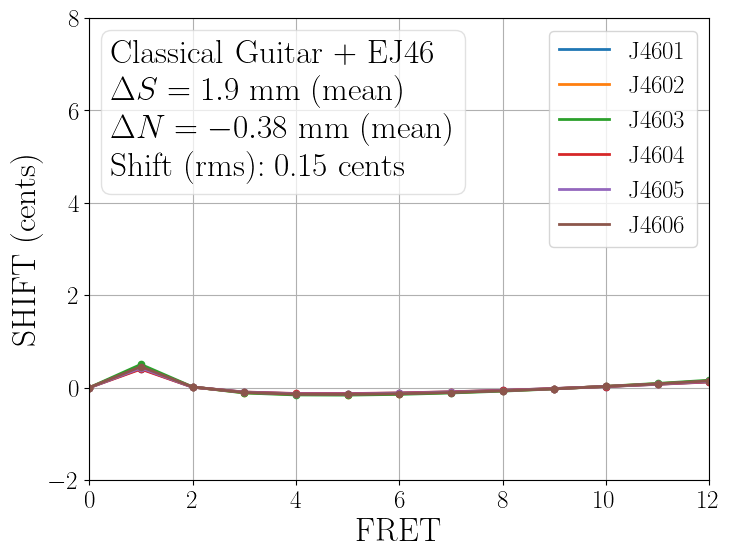

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46_setbacks.tex

Classical Guitar + EJ46 : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46_mean.pdf

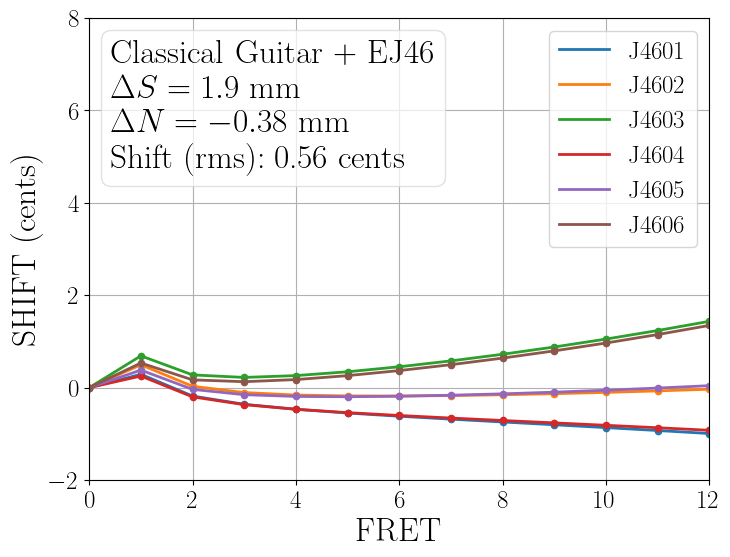

Classical Guitar + EJ46 : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46_harmonic.pdf

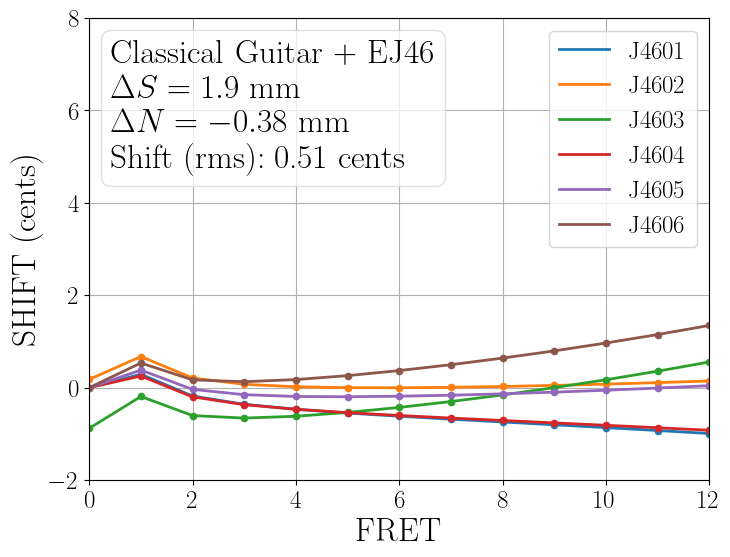

D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)

Classical Guitar + EJ44 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4401  E_4     0.368         0.401          73.6   
J4402  B_3     0.423         0.544          56.1   
J4403  G_3     0.528         0.891          57.8   
J4404  D_3     0.381         2.007          73.1   
J4405  A_2     0.457         3.486          71.3   
J4406  E_2     0.571         6.134          70.4   
String  R   R std kappa    B_0   E_eff (GPa)
J4401  25.8  0.4   52.6  0.00206     9.09   
J4402  27.7  0.9   56.3  0.00244     5.62   
J4403  29.6  0.6   60.2  0.00315     3.97   
J4404  25.0  0.5   51.0  0.00209     8.17   
J4405  23.7  0.2   48.5  0.00245     5.26   
J4406  26.6  0.2   54.3  0.00324     3.72   

Classical Guitar + EJ44 : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej44_null.pdf

Classical Guitar + EJ44 : Approximate 

Classical Guitar + EJ44 : RMS Fit 

Classical Guitar + EJ44 : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej44_full.pdf

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej44_setbacks.tex

Classical Guitar + EJ44 : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej44_mean.pdf

Classical Guitar + EJ44 : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej44_harmonic.pdf

D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)

Classical Guitar + EJ45FF : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
 String Note Radius (mm) Density (mg/mm) Tension (N)
J4501FF E_4     0.305         0.464          85.3   
J4502FF B_3     0.345         0.607          62.6   
J4503FF G_3     0.420         0.893          58.0   
J4504FF D_3     0.356         1.643          59.9   
J4505FF A_2     0.445         3.089          63.2   
J4506FF E_2     0.559         5.715          65.6   
 String  R   R std kappa    B_0   E_eff (GPa)
J4501FF 21.8  0.4   44.6  0.00157    13.04   
J4502FF 26.0  0.6   53.1  0.00194     8.86   
J4503FF 26.9  0.8   54.7  0.00239     5.71   
J4504FF 24.3  0.4   49.6  0.00193     7.47   
J4505FF 26.9  0.4   54.7  0.00253     5.57   
J4506FF 23.5  0.9   47.9  0.00298     3.20   

Classical Guitar + EJ45FF : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45ff_null.pdf

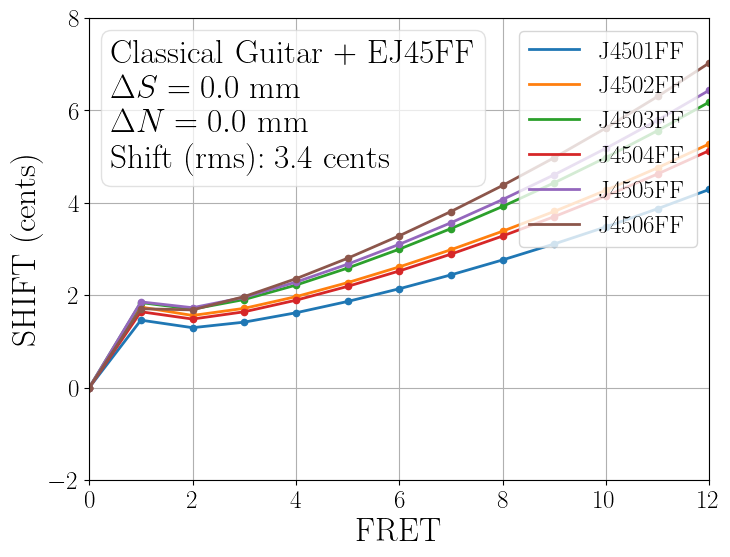

Classical Guitar + EJ45FF : Approximate 

Classical Guitar + EJ45FF : RMS Fit 

Classical Guitar + EJ45FF : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45ff_full.pdf

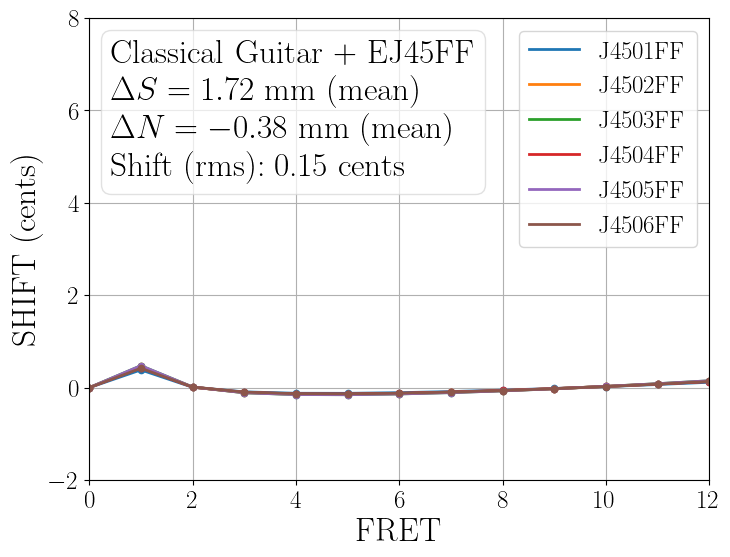

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej45ff_setbacks.tex

Classical Guitar + EJ45FF : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45ff_mean.pdf

Classical Guitar + EJ45FF : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej45ff_harmonic.pdf

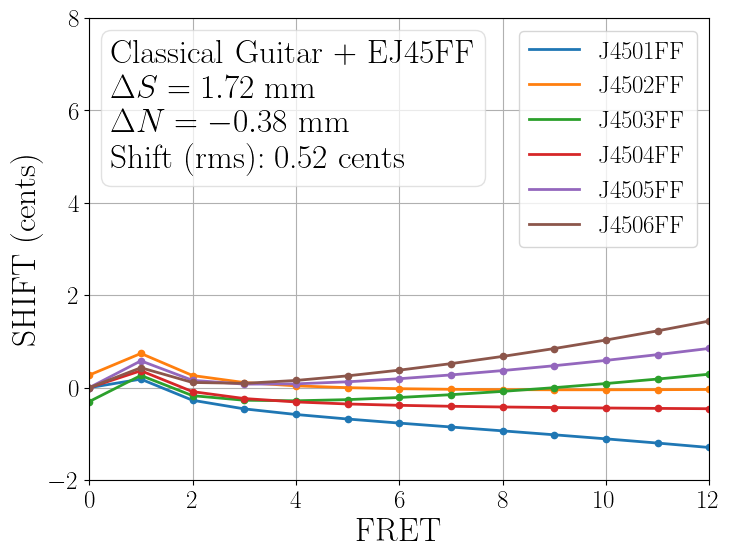

D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)

Classical Guitar + EJ46FF : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 0.00 mm
 String Note Radius (mm) Density (mg/mm) Tension (N)
J4601FF E_4     0.315         0.500          91.8   
J4602FF B_3     0.356         0.643          66.3   
J4603FF G_3     0.431         0.946          61.4   
J4604FF D_3     0.368         1.839          67.0   
J4605FF A_2     0.457         3.554          72.7   
J4606FF E_2     0.584         6.125          70.3   
 String  R   R std kappa    B_0   E_eff (GPa)
J4601FF 22.2  0.3   45.4  0.00163    13.38   
J4602FF 23.1  0.4   47.1  0.00188     7.86   
J4603FF 25.8  0.6   52.6  0.00240     5.55   
J4604FF 23.1  0.4   47.2  0.00195     7.42   
J4605FF 23.8  0.2   48.6  0.00245     5.37   
J4606FF 23.1  0.4   47.2  0.00309     3.09   

Classical Guitar + EJ46FF : Uncompensated 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46ff_null.pdf

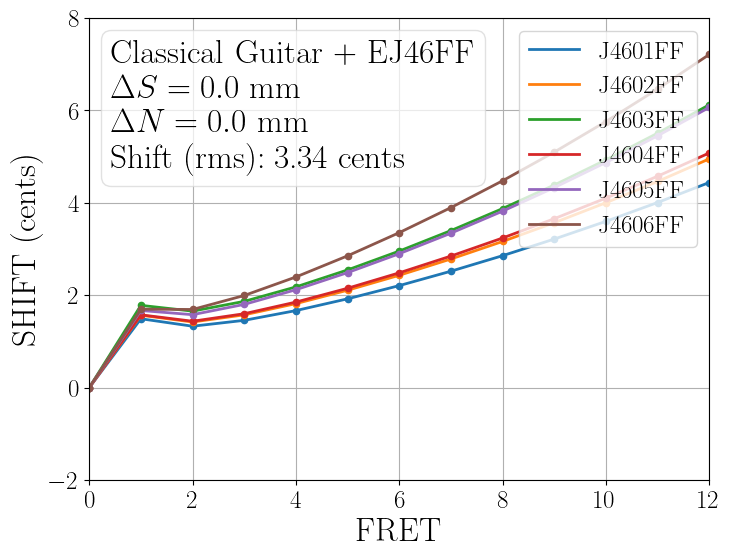

Classical Guitar + EJ46FF : Approximate 

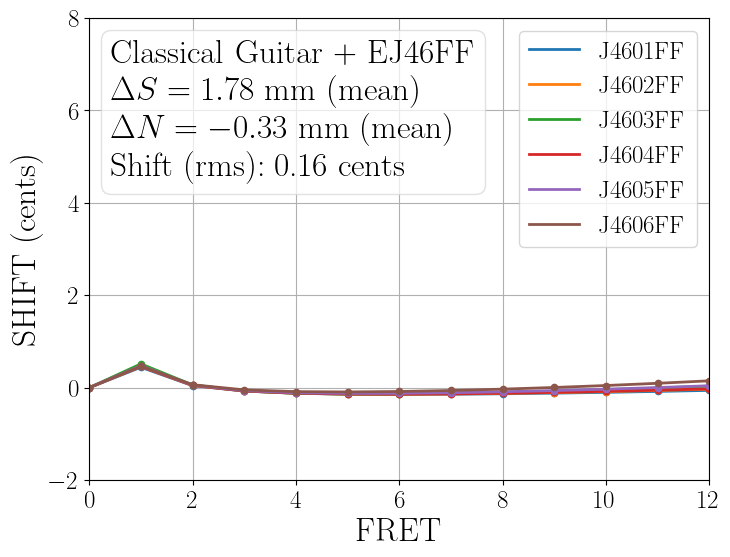

Classical Guitar + EJ46FF : RMS Fit 

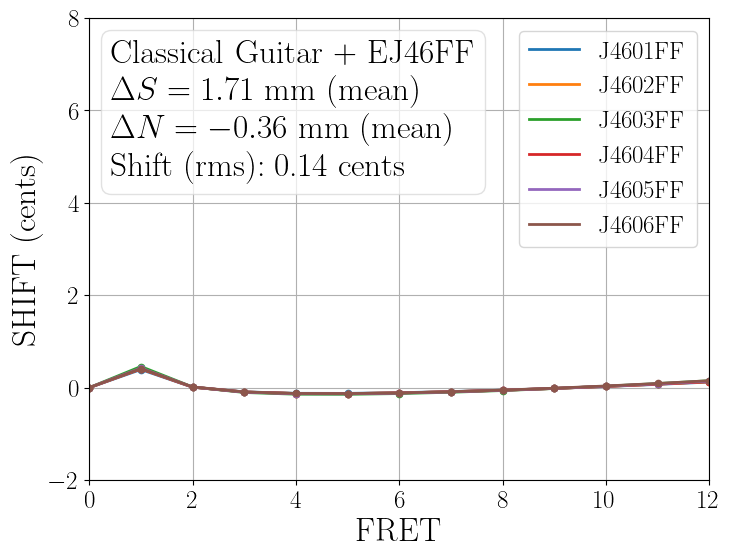

Classical Guitar + EJ46FF : BFGS Minimize 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46ff_full.pdf

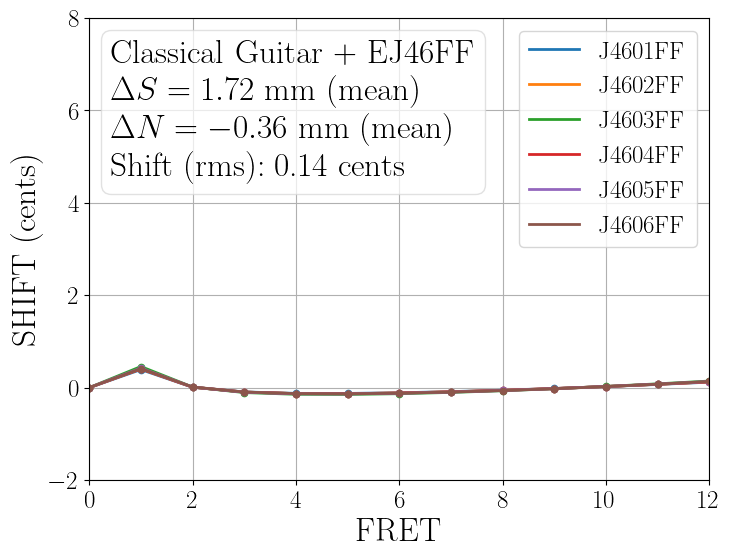

Saved C:/vcs/git/docs/classical-guitar/cgic/files/tbl_ej46ff_setbacks.tex

Classical Guitar + EJ46FF : BFGS Minimize Mean 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46ff_mean.pdf

Classical Guitar + EJ46FF : BFGS Minimize Mean Harmonic 

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/shift_classicalguitar_ej46ff_harmonic.pdf

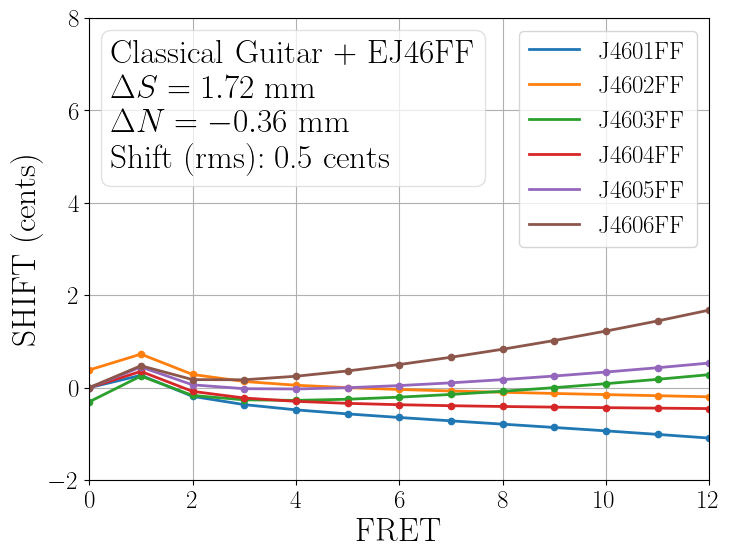

<IPython.core.display.Math object>

EJ43       EJ45       EJ46       EJ44     EJ45FF  \
Uncompensated      4.713128   3.652157   3.664932   3.828982   3.401170   
Approximate        0.244100   0.165397   0.163163   0.171403   0.166107   
RMS Fit            0.233467   0.155235   0.153787   0.162248   0.152258   
RMS Minimize       0.233411   0.155151   0.153698   0.162150   0.152202   
Uncomp/Approx     19.308207  22.081123  22.461833  22.339071  20.475745   
Uncomp/Fit        20.187550  23.526649  23.831180  23.599588  22.338191   
Uncomp/Min        20.192395  23.539302  23.845095  23.613806  22.346483   
Approx - Min (%)   4.579341   6.603735   6.158276   5.706306   9.136357   
Fit - Min (%)      0.024002   0.053780   0.058389   0.060247   0.037118   

                     EJ46FF  
Uncompensated      3.344297  
Approximate        0.157313  
RMS Fit            0.143906  
RMS Minimize       0.143834  
Uncomp/Approx     21.258861  
Uncomp/Fit        23.239530  
Uncomp/Min        23.251110  
Approx - Min (%)   9.371379  
Fit - Min (%)      0.049830

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/hist_r.pdf

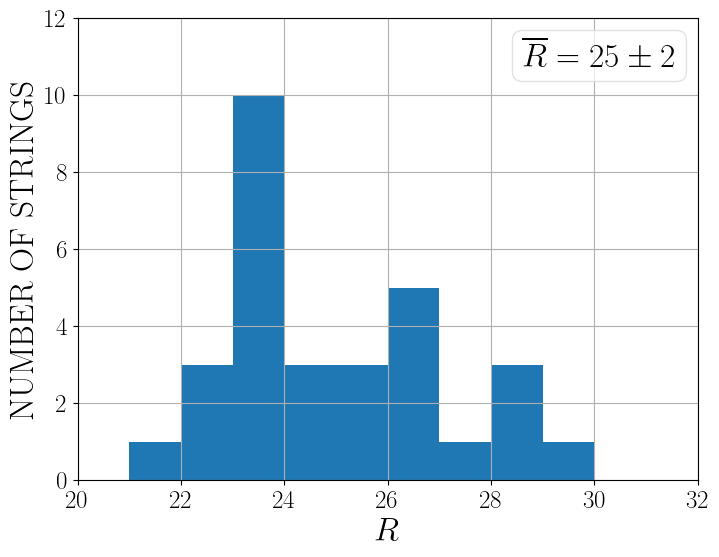

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/fit_ds.pdf

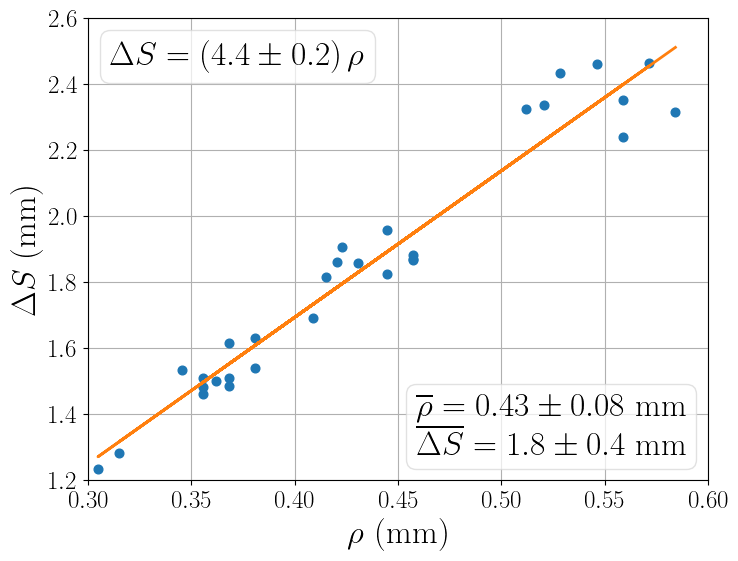

Saved C:/vcs/git/docs/classical-guitar/cgic/figures/hist_dn.pdf

In [44]:
guitar_name = 'Classical Guitar'
scale_length = 650.0
b = 1.0
c = 4.0
d = 0.0

params = { 'name' : guitar_name,
           'x0' : scale_length,
           'b' : b,
           'c' : c,
           'd' : d }

string_count = 6
max_fret = 12

path_guitar_strings_specs = gitpath + '/data/guitar_strings_specs.xlsx'
path_guitar_strings_props = gitpath + '/data/guitar_strings_props.xlsx'
save_fig_dir = gitpath + '/cgic/figures/'
save_tbl_dir = gitpath + '/cgic/files/'
show = True

strings_names = [ "D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)"
                ]
sheet_names = [ 'EJ43', 'EJ45', 'EJ46', 'EJ44', 'EJ45FF', 'EJ46FF' ]

setbacks = init_setbacks(string_count)

for strings_name, sheet_name in zip(strings_names, sheet_names):
    print('\n[bold magenta]' + strings_name + '[/bold magenta]\n')
    
    setbacks, strings = compensate(strings_name, sheet_name, setbacks)

multistring(setbacks)

## Alhambra 8P ($d = 10$ mm)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)

Classical Guitar + EJ43 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4301  E_4     0.349         0.361          66.4   
J4302  B_3     0.403         0.487          50.2   
J4303  G_3     0.504         0.808          52.5   
J4304  D_3     0.356         1.822          66.4   
J4305  A_2     0.419         2.741          56.0   
J4306  E_2     0.533         5.158          59.2   
String  R   R std kappa    B_0   E_eff (GPa)
J4301  37.8  0.5   76.6  0.00235    13.28   
J4302  42.6  1.0   86.2  0.00287     8.50   
J4303  55.0  0.4  111.1  0.00409     7.30   
J4304  31.4  1.2   63.7  0.00218    10.65   
J4305  26.1  0.5   53.2  0.00235     5.40   
J4306  28.5  1.1   57.9  0.00312     3.83   

Classical Guitar + EJ43 : Uncompensated 

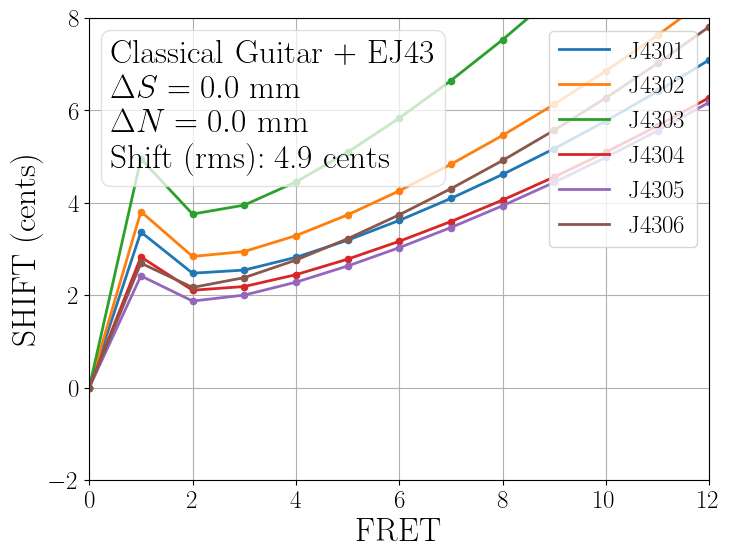

Classical Guitar + EJ43 : Approximate 

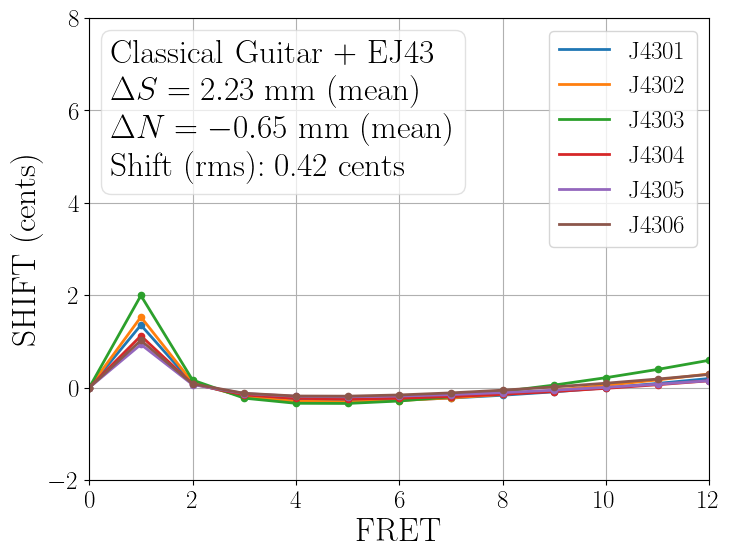

Classical Guitar + EJ43 : RMS Fit 

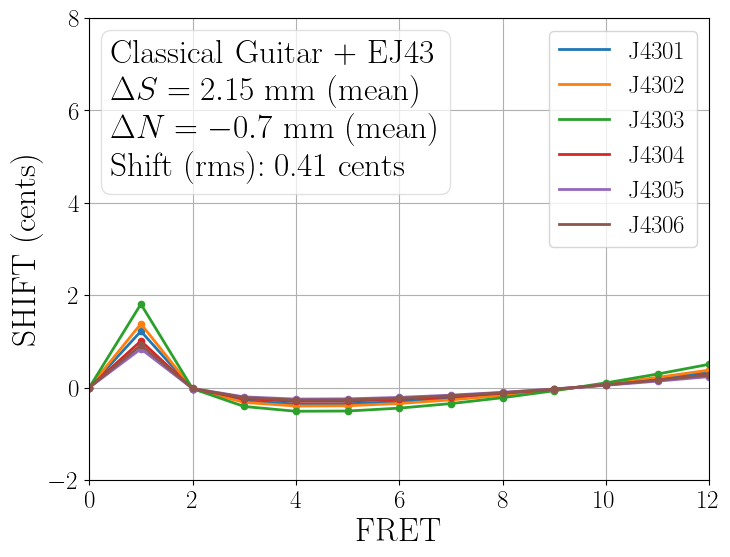

Classical Guitar + EJ43 : BFGS Minimize 

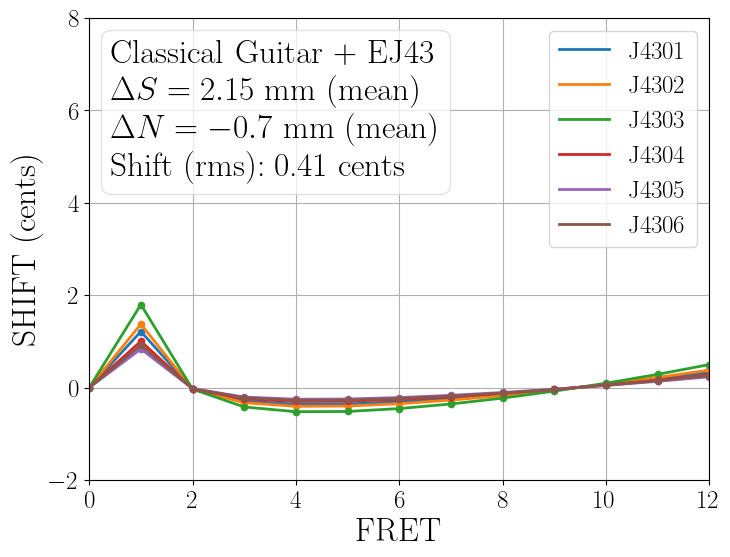

Classical Guitar + EJ43 : BFGS Minimize Mean 

Classical Guitar + EJ43 : BFGS Minimize Mean Harmonic 

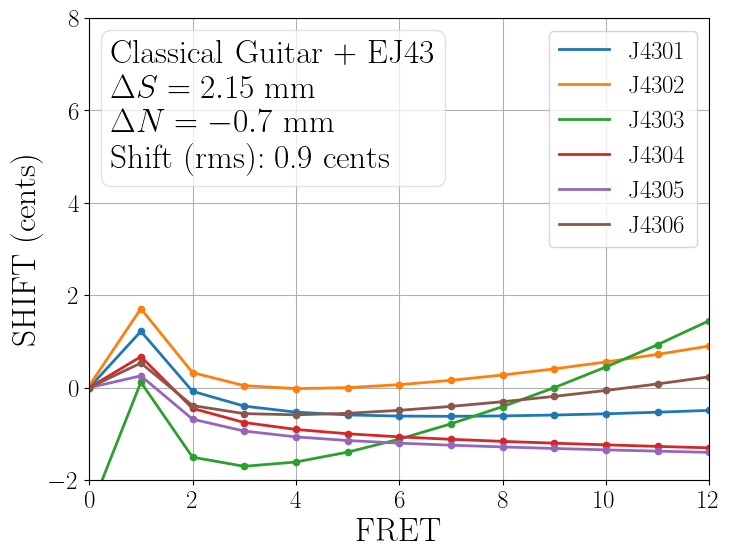

D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)

Classical Guitar + EJ45 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4501  E_4     0.356         0.374          68.6   
J4502  B_3     0.409         0.505          52.0   
J4503  G_3     0.512         0.836          54.2   
J4504  D_3     0.368         1.920          70.0   
J4505  A_2     0.445         3.289          67.3   
J4506  E_2     0.546         5.470          62.8   
String  R   R std kappa    B_0   E_eff (GPa)
J4501  23.6  0.5   48.2  0.00190     8.33   
J4502  23.8  0.7   48.7  0.00220     4.82   
J4503  28.8  0.6   58.6  0.00301     3.87   
J4504  22.5  0.8   46.0  0.00192     7.56   
J4505  23.9  0.7   48.7  0.00239     5.28   
J4506  28.6  0.4   58.2  0.00321     3.90   

Classical Guitar + EJ45 : Uncompensated 

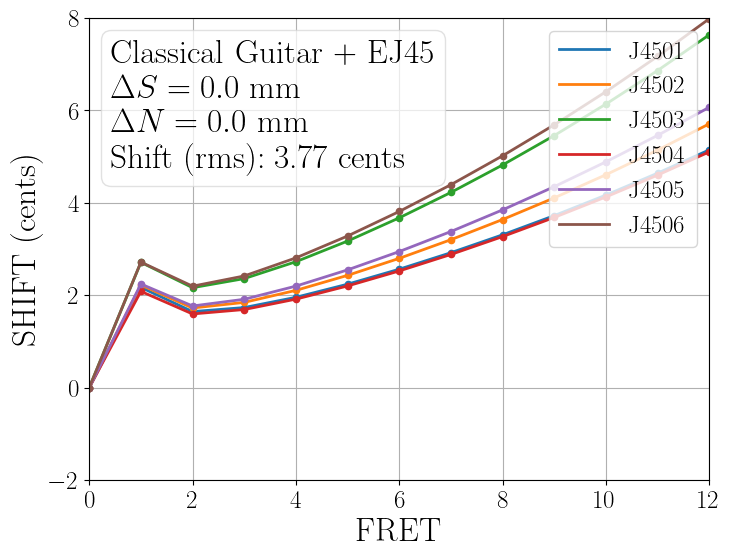

Classical Guitar + EJ45 : Approximate 

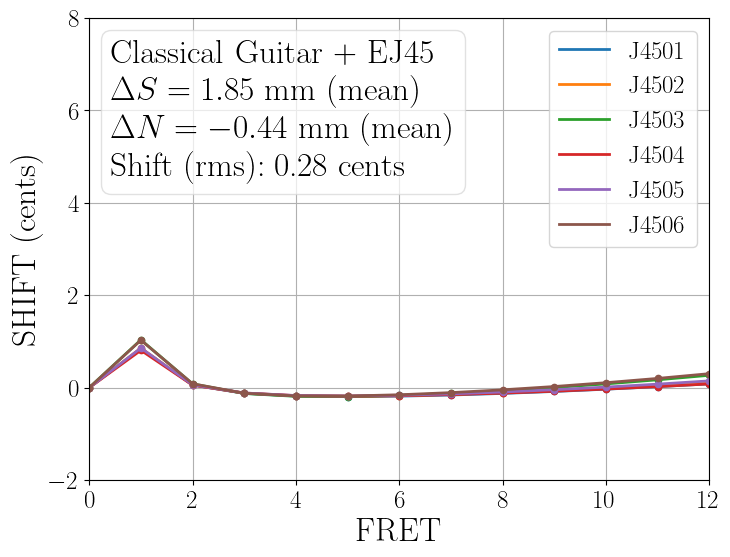

Classical Guitar + EJ45 : RMS Fit 

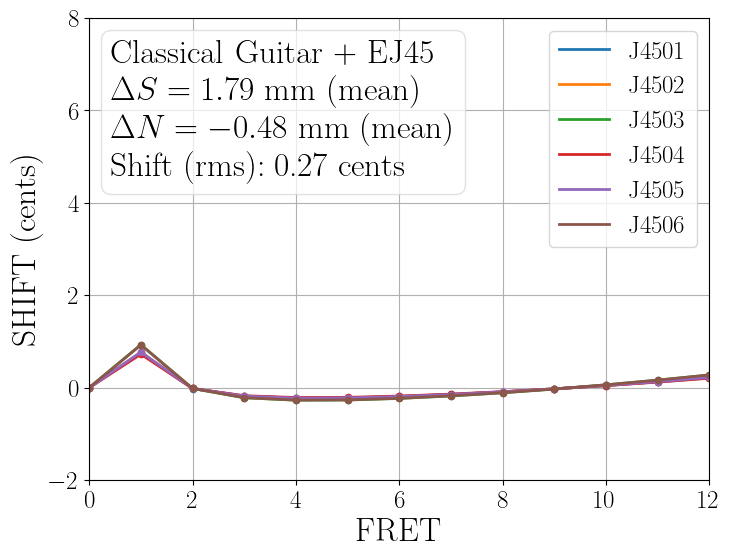

Classical Guitar + EJ45 : BFGS Minimize 

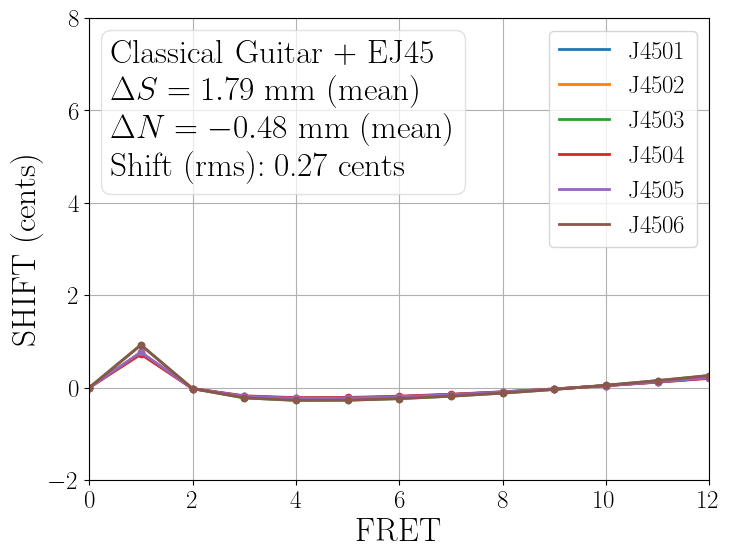

Classical Guitar + EJ45 : BFGS Minimize Mean 

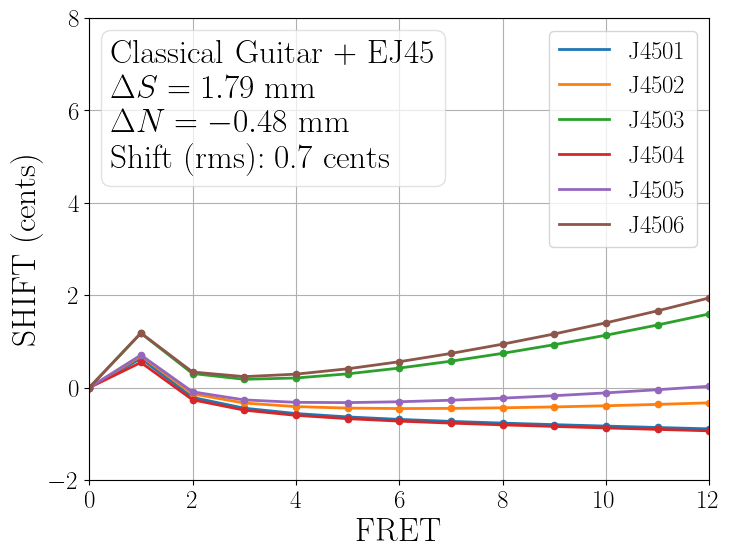

Classical Guitar + EJ45 : BFGS Minimize Mean Harmonic 

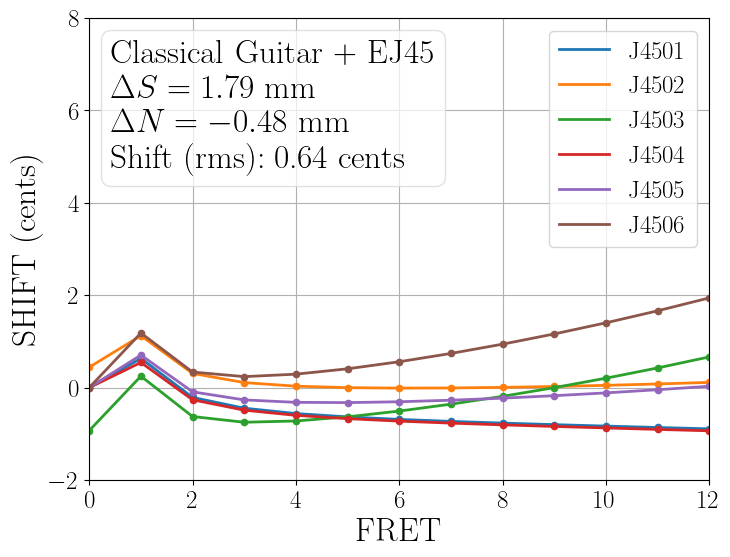

D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)

Classical Guitar + EJ46 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4601  E_4     0.362         0.386          70.9   
J4602  B_3     0.415         0.522          53.8   
J4603  G_3     0.521         0.856          55.6   
J4604  D_3     0.381         2.007          73.1   
J4605  A_2     0.457         3.486          71.3   
J4606  E_2     0.559         5.666          65.0   
String  R   R std kappa    B_0   E_eff (GPa)
J4601  23.5  0.5   47.9  0.00193     8.25   
J4602  26.2  0.3   53.5  0.00234     5.31   
J4603  28.3  1.0   57.5  0.00304     3.75   
J4604  22.7  0.3   46.4  0.00200     7.43   
J4605  24.0  0.2   49.0  0.00246     5.32   
J4606  25.5  0.3   51.9  0.00310     3.44   

Classical Guitar + EJ46 : Uncompensated 

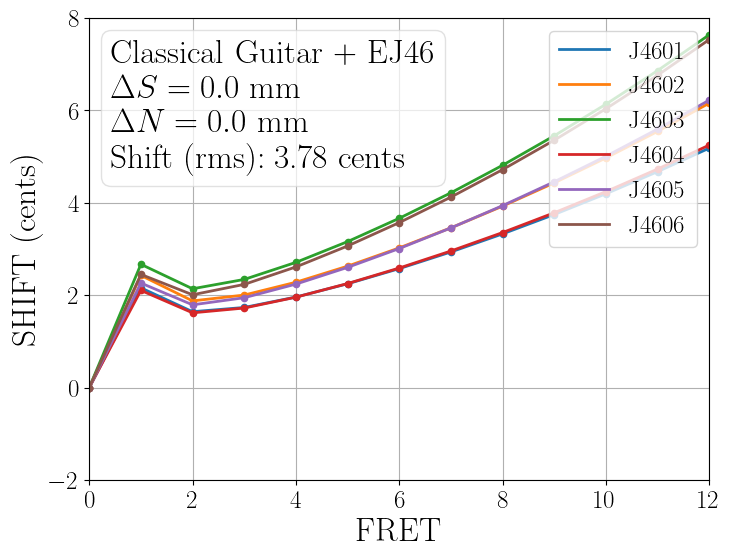

Classical Guitar + EJ46 : Approximate 

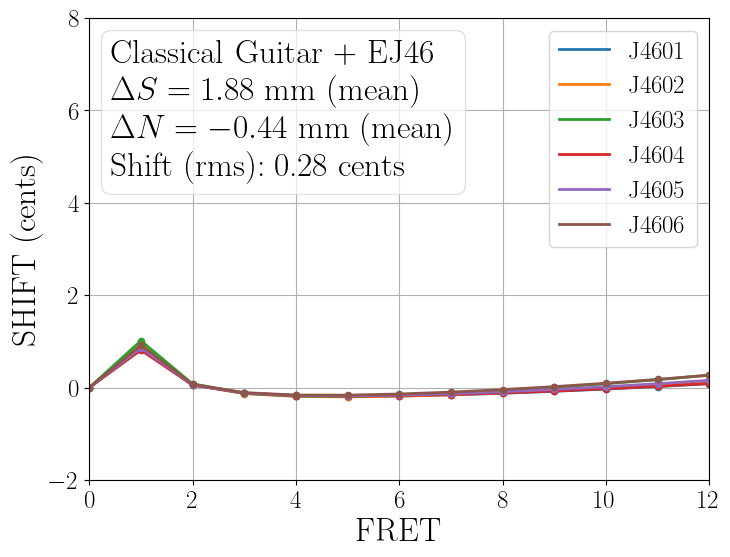

Classical Guitar + EJ46 : RMS Fit 

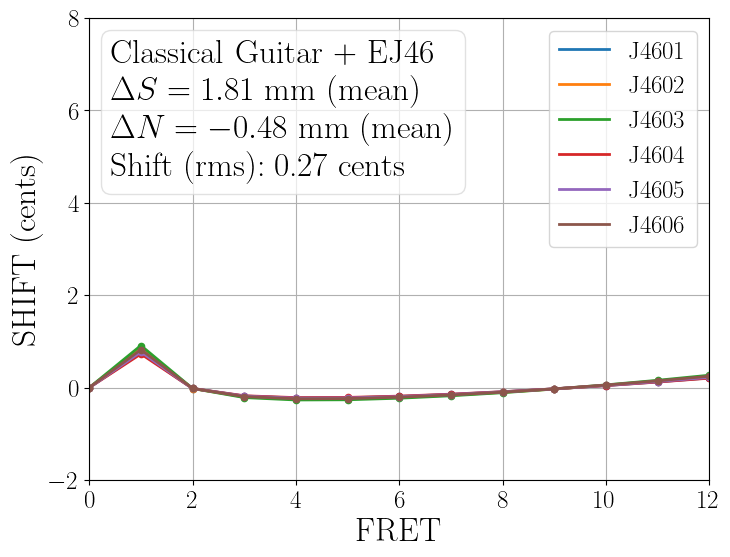

Classical Guitar + EJ46 : BFGS Minimize 

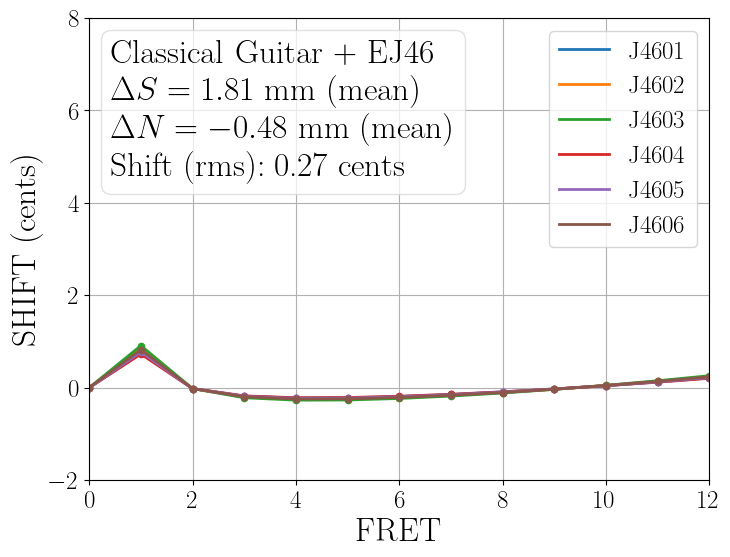

Classical Guitar + EJ46 : BFGS Minimize Mean 

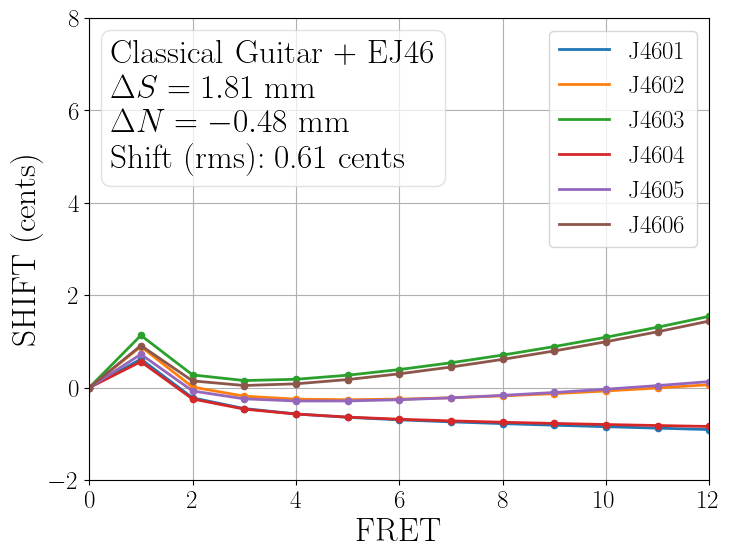

Classical Guitar + EJ46 : BFGS Minimize Mean Harmonic 

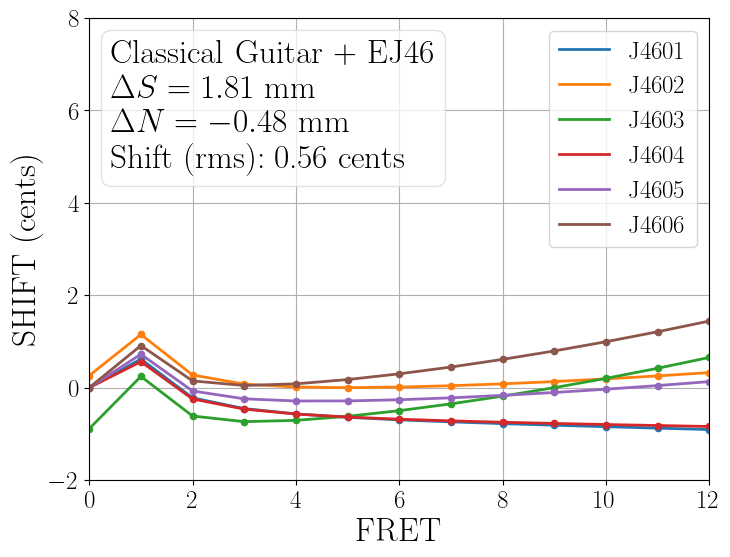

D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)

Classical Guitar + EJ44 : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
String Note Radius (mm) Density (mg/mm) Tension (N)
J4401  E_4     0.368         0.401          73.6   
J4402  B_3     0.423         0.544          56.1   
J4403  G_3     0.528         0.891          57.8   
J4404  D_3     0.381         2.007          73.1   
J4405  A_2     0.457         3.486          71.3   
J4406  E_2     0.571         6.134          70.4   
String  R   R std kappa    B_0   E_eff (GPa)
J4401  25.8  0.4   52.6  0.00206     9.09   
J4402  27.7  0.9   56.3  0.00244     5.62   
J4403  29.6  0.6   60.2  0.00315     3.97   
J4404  25.0  0.5   51.0  0.00209     8.17   
J4405  23.7  0.2   48.5  0.00245     5.26   
J4406  26.6  0.2   54.3  0.00324     3.72   

Classical Guitar + EJ44 : Uncompensated 

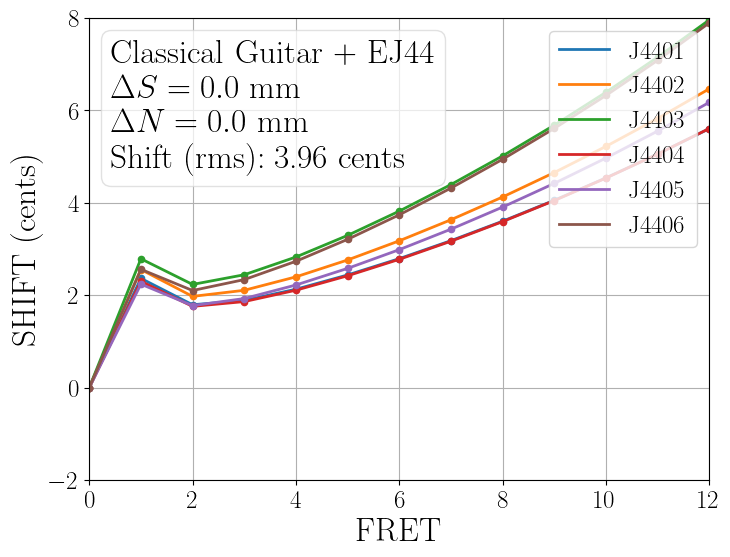

Classical Guitar + EJ44 : Approximate 

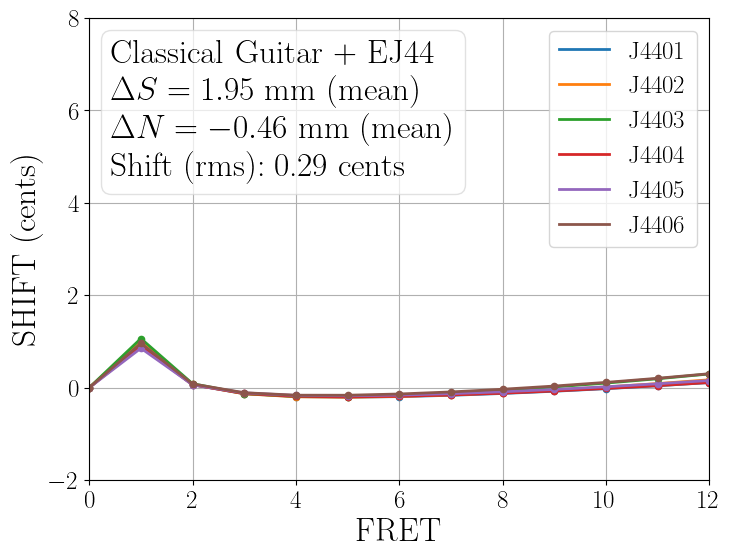

Classical Guitar + EJ44 : RMS Fit 

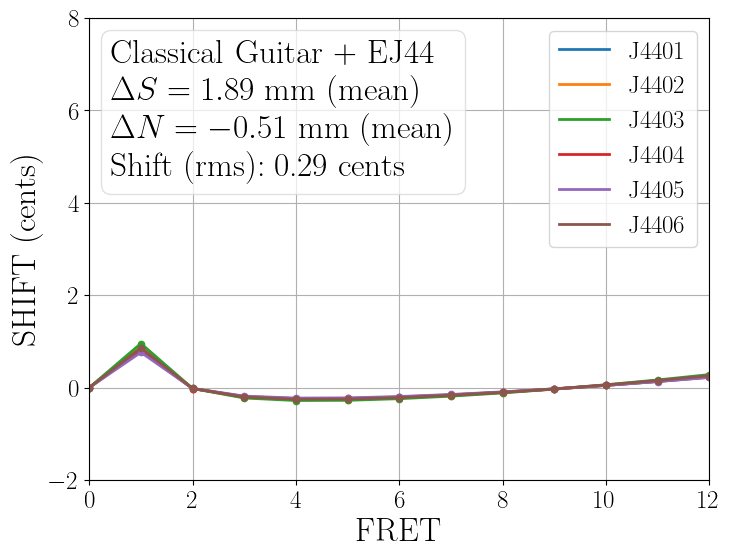

Classical Guitar + EJ44 : BFGS Minimize 

Classical Guitar + EJ44 : BFGS Minimize Mean 

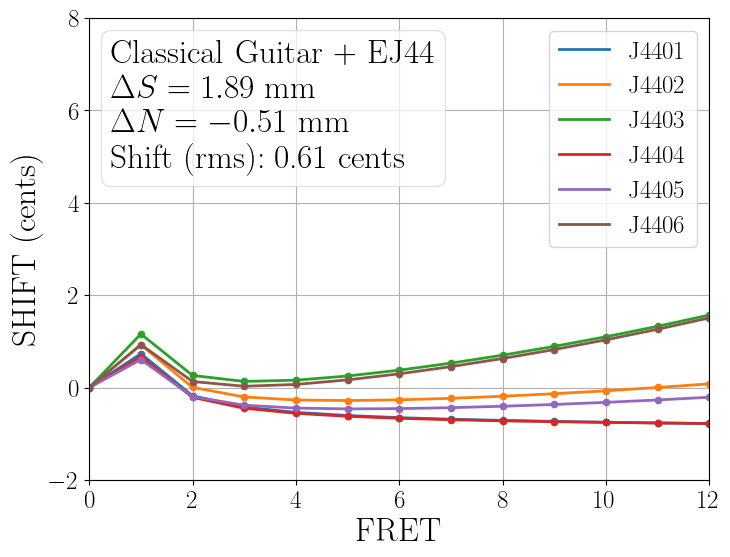

Classical Guitar + EJ44 : BFGS Minimize Mean Harmonic 

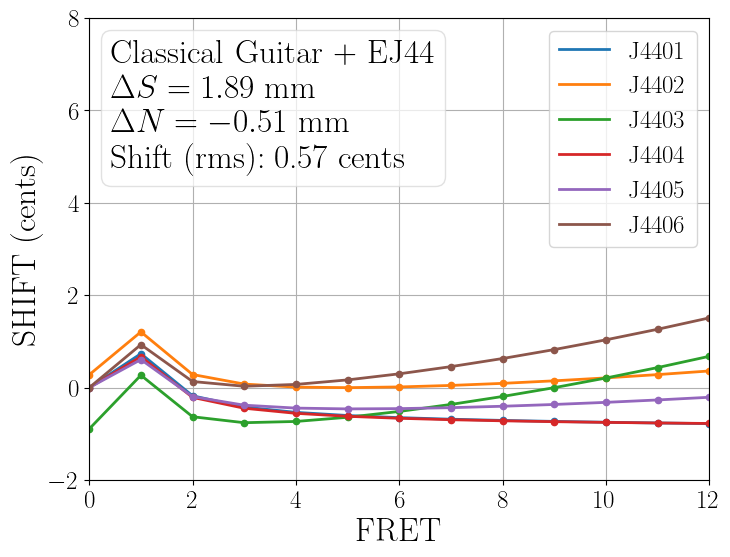

D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)

Classical Guitar + EJ45FF : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
 String Note Radius (mm) Density (mg/mm) Tension (N)
J4501FF E_4     0.305         0.464          85.3   
J4502FF B_3     0.345         0.607          62.6   
J4503FF G_3     0.420         0.893          58.0   
J4504FF D_3     0.356         1.643          59.9   
J4505FF A_2     0.445         3.089          63.2   
J4506FF E_2     0.559         5.715          65.6   
 String  R   R std kappa    B_0   E_eff (GPa)
J4501FF 21.8  0.4   44.6  0.00157    13.04   
J4502FF 26.0  0.6   53.1  0.00194     8.86   
J4503FF 26.9  0.8   54.7  0.00239     5.71   
J4504FF 24.3  0.4   49.6  0.00193     7.47   
J4505FF 26.9  0.4   54.7  0.00253     5.57   
J4506FF 23.5  0.9   47.9  0.00298     3.20   

Classical Guitar + EJ45FF : Uncompensated 

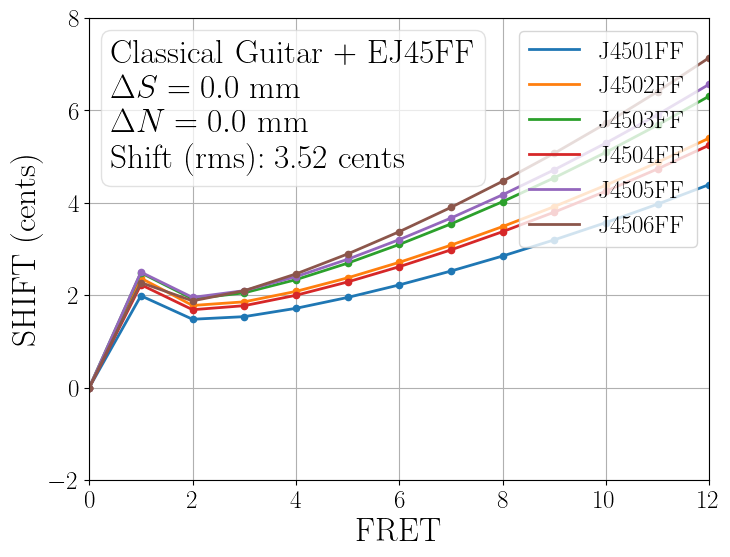

Classical Guitar + EJ45FF : Approximate 

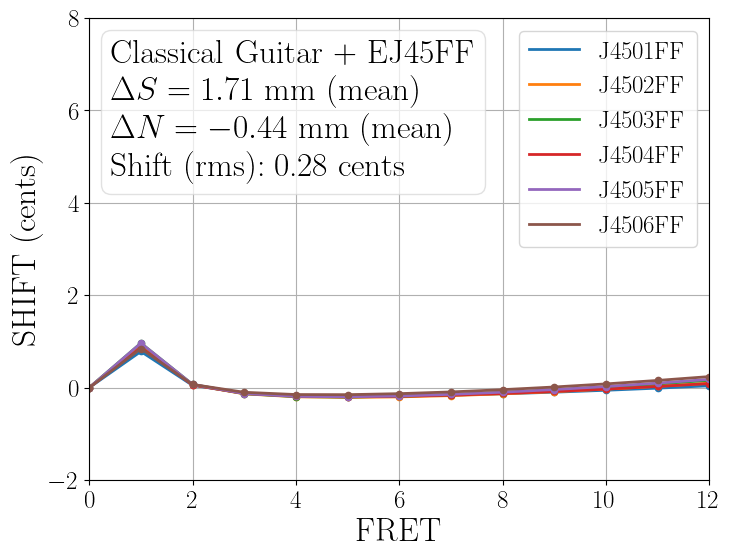

Classical Guitar + EJ45FF : RMS Fit 

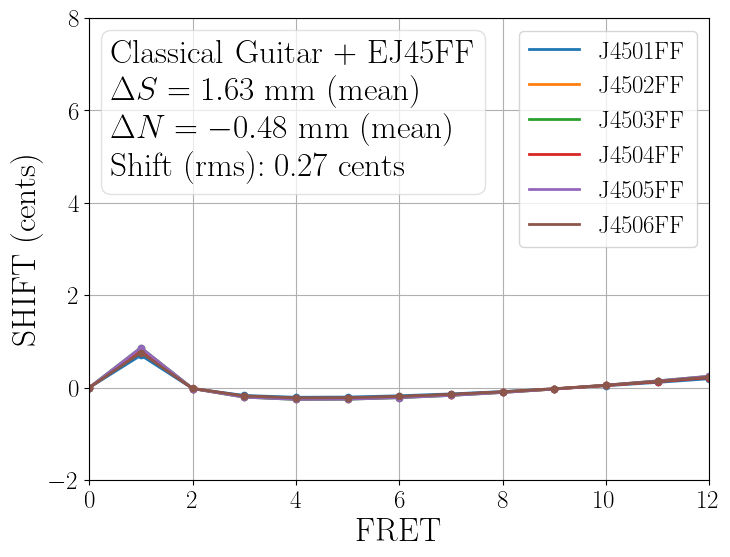

Classical Guitar + EJ45FF : BFGS Minimize 

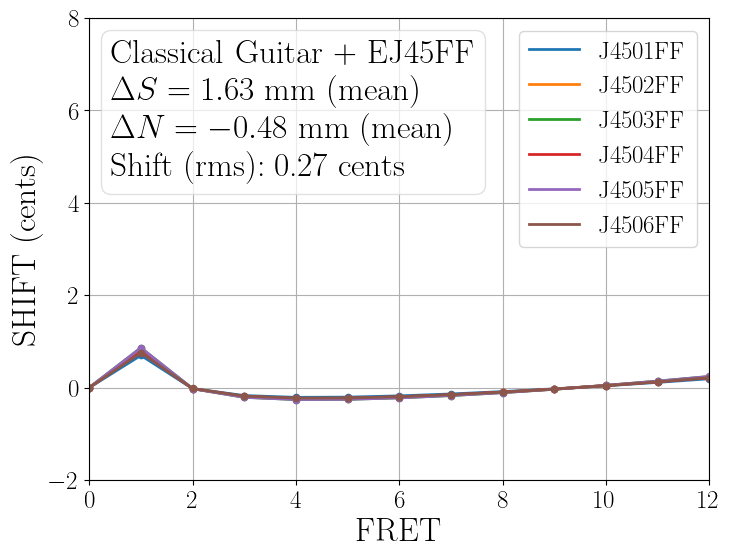

Classical Guitar + EJ45FF : BFGS Minimize Mean 

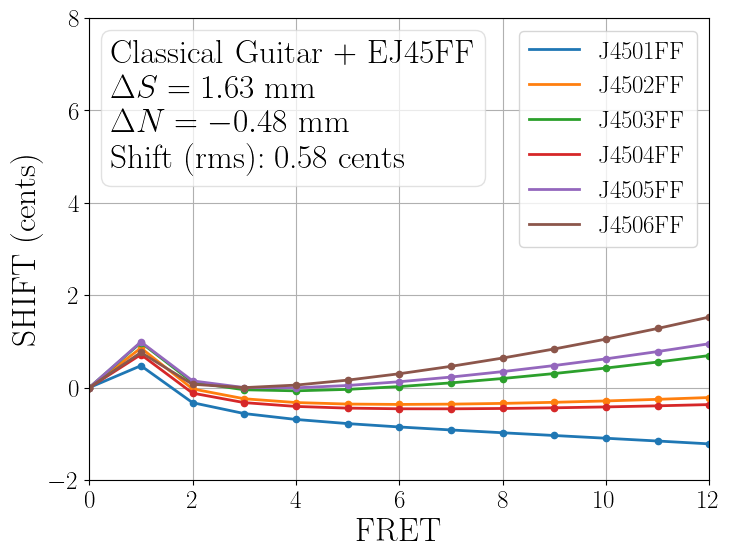

Classical Guitar + EJ45FF : BFGS Minimize Mean Harmonic 

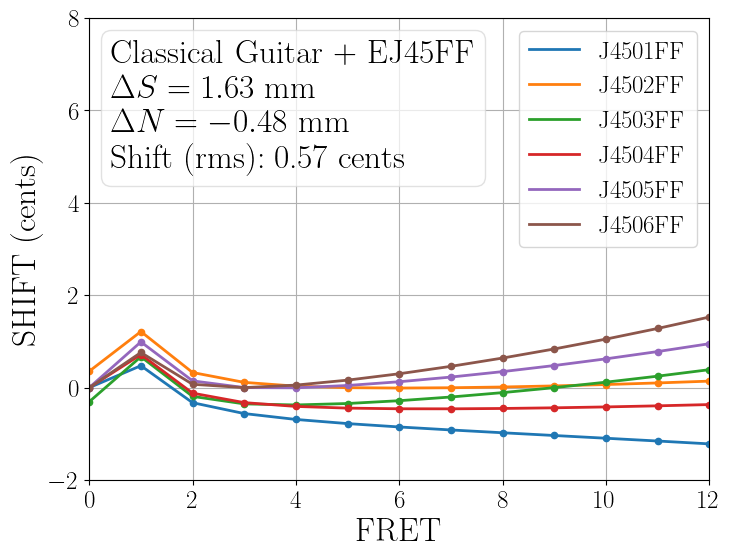

D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)

Classical Guitar + EJ46FF : Guitar : BaseClass
x0: 650.00 mm
ds: 0.00 mm
dn: 0.00 mm
b: 1.00 mm
c: 4.00 mm
d: 10.00 mm
 String Note Radius (mm) Density (mg/mm) Tension (N)
J4601FF E_4     0.315         0.500          91.8   
J4602FF B_3     0.356         0.643          66.3   
J4603FF G_3     0.431         0.946          61.4   
J4604FF D_3     0.368         1.839          67.0   
J4605FF A_2     0.457         3.554          72.7   
J4606FF E_2     0.584         6.125          70.3   
 String  R   R std kappa    B_0   E_eff (GPa)
J4601FF 22.2  0.3   45.4  0.00163    13.38   
J4602FF 23.1  0.4   47.1  0.00188     7.86   
J4603FF 25.8  0.6   52.6  0.00240     5.55   
J4604FF 23.1  0.4   47.2  0.00195     7.42   
J4605FF 23.8  0.2   48.6  0.00245     5.37   
J4606FF 23.1  0.4   47.2  0.00309     3.09   

Classical Guitar + EJ46FF : Uncompensated 

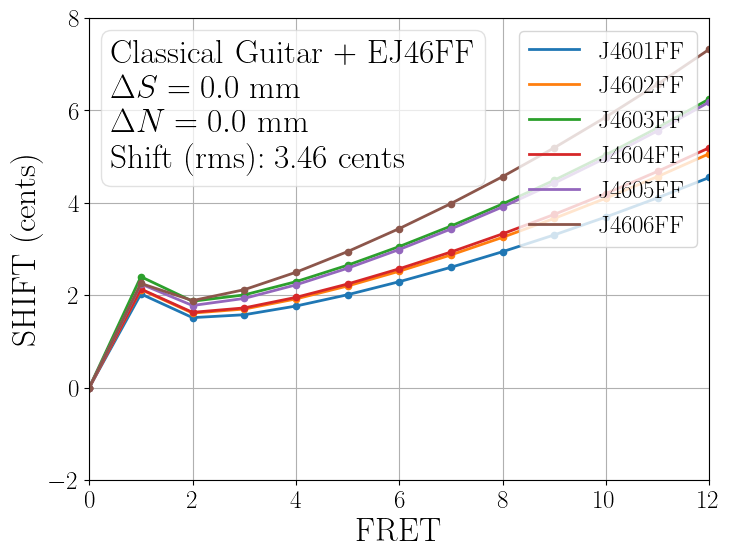

Classical Guitar + EJ46FF : Approximate 

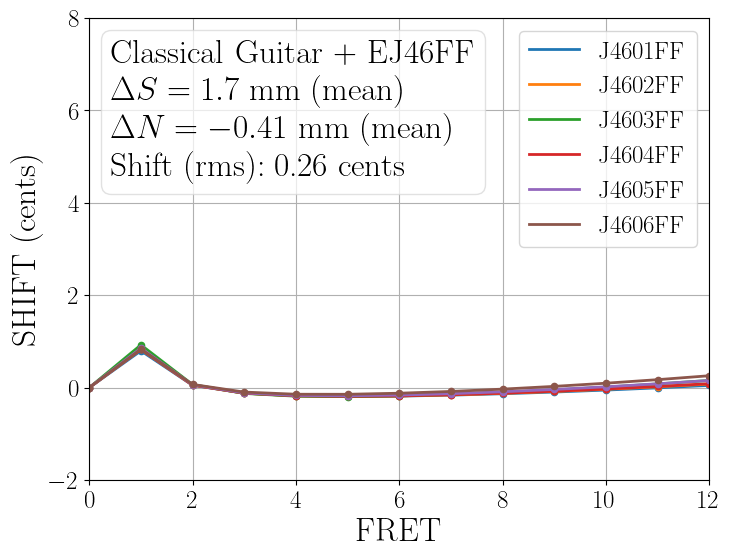

Classical Guitar + EJ46FF : RMS Fit 

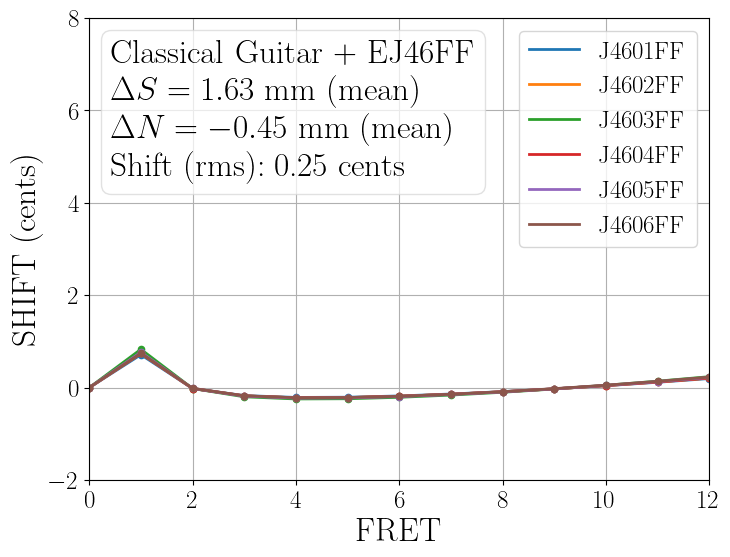

Classical Guitar + EJ46FF : BFGS Minimize 

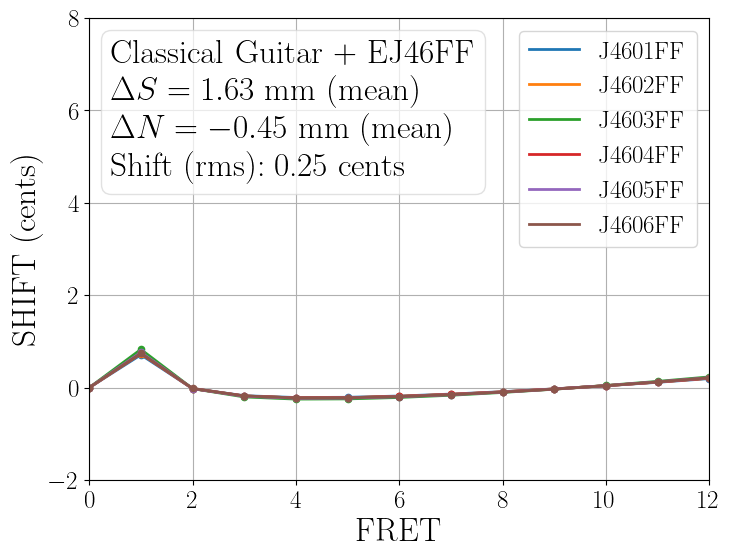

Classical Guitar + EJ46FF : BFGS Minimize Mean 

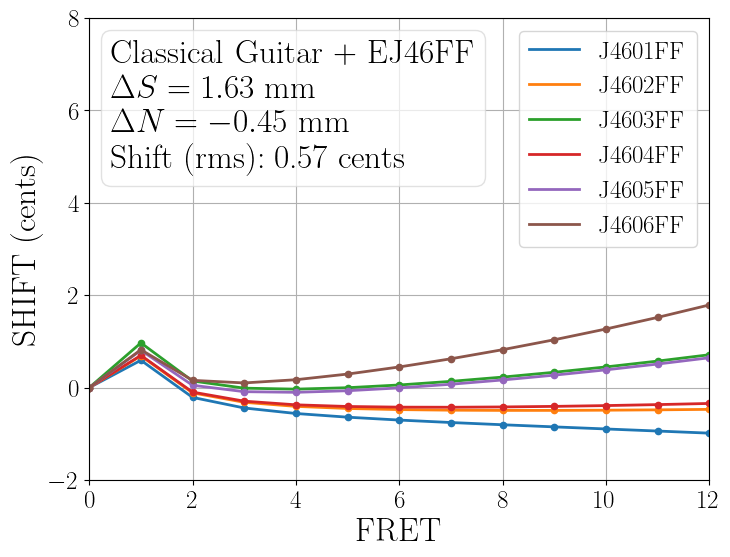

Classical Guitar + EJ46FF : BFGS Minimize Mean Harmonic 

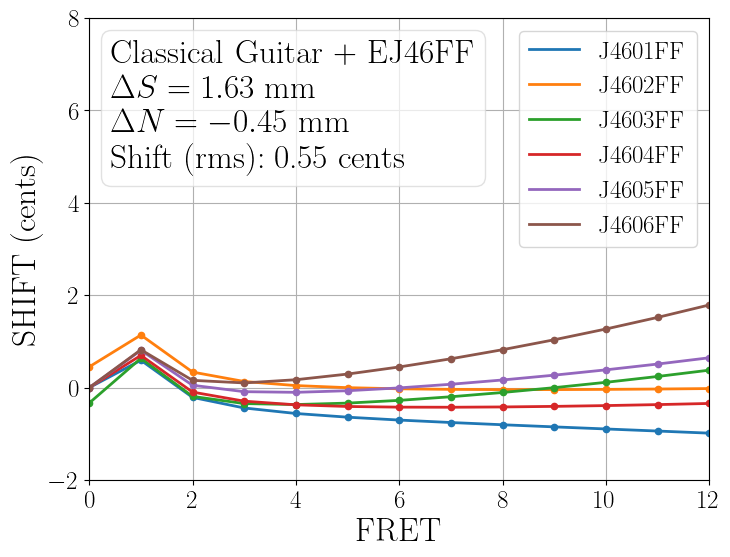

<IPython.core.display.Math object>

EJ43       EJ45       EJ46       EJ44     EJ45FF  \
Uncompensated      4.898578   3.773397   3.784625   3.955135   3.521622   
Approximate        0.423390   0.280935   0.277942   0.293255   0.276584   
RMS Fit            0.412967   0.273462   0.270841   0.285695   0.268790   
RMS Minimize       0.412932   0.273422   0.270798   0.285649   0.268762   
Uncomp/Approx     11.569908  13.431578  13.616600  13.487010  12.732553   
Uncomp/Fit        11.861909  13.798634  13.973619  13.843899  13.101760   
Uncomp/Min        11.862927  13.800619  13.975805  13.846145  13.103127   
Approx - Min (%)   2.532596   2.747561   2.637994   2.662817   2.910443   
Fit - Min (%)      0.008582   0.014386   0.015646   0.016220   0.010436   

                     EJ46FF  
Uncompensated      3.457154  
Approximate        0.261597  
RMS Fit            0.253839  
RMS Minimize       0.253805  
Uncomp/Approx     13.215561  
Uncomp/Fit        13.619454  
Uncomp/Min        13.621312  
Approx - Min (%)   3.070258  
Fit - Min (%)      0.013647

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

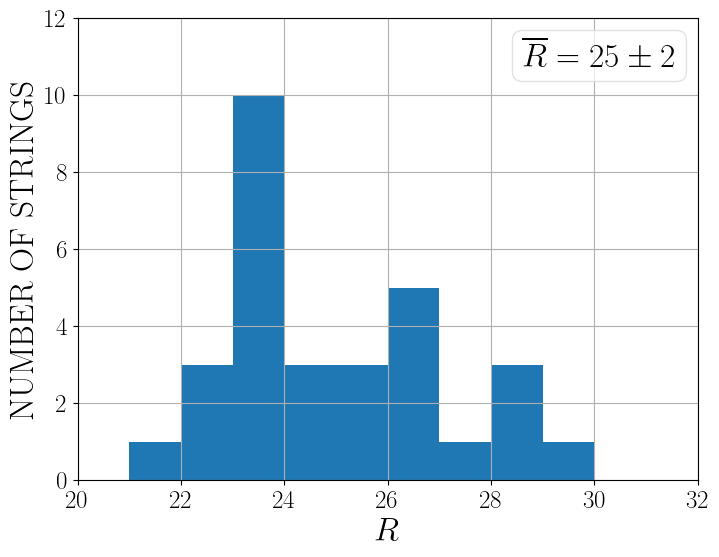

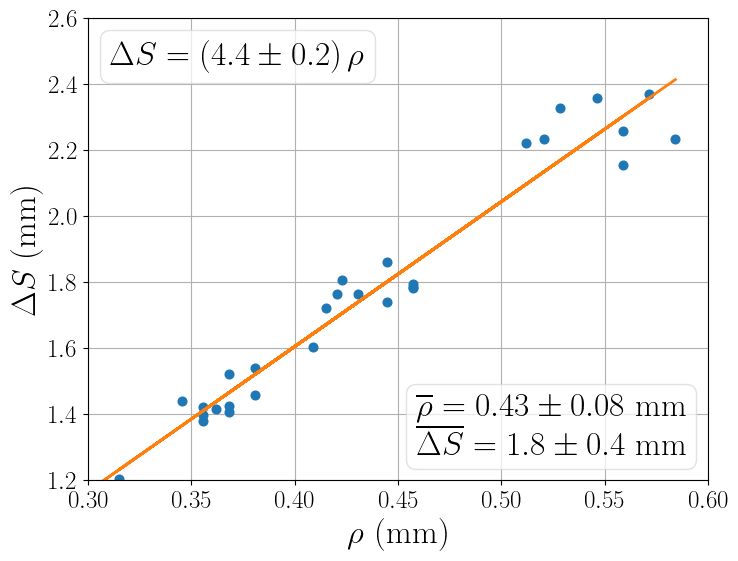

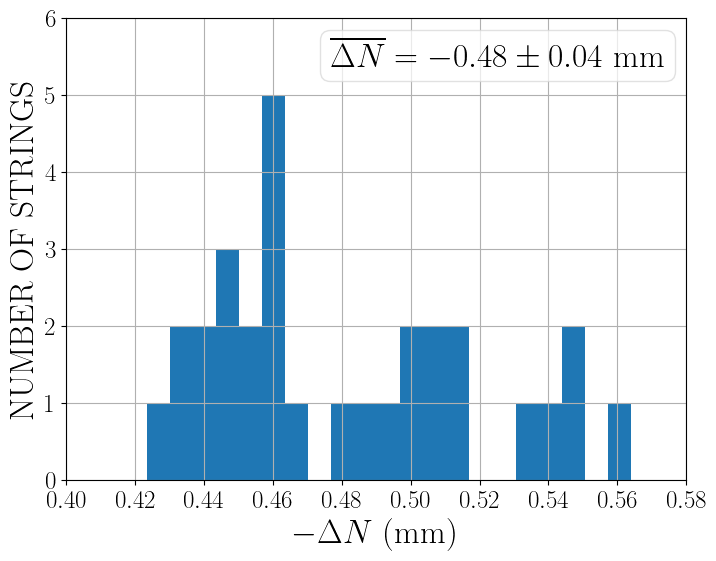

In [46]:
guitar_name = 'Classical Guitar'
scale_length = 650.0
b = 1.0
c = 4.0
d = 10.0

params = { 'name' : guitar_name,
           'x0' : scale_length,
           'b' : b,
           'c' : c,
           'd' : d }

string_count = 6
max_fret = 12

path_guitar_strings_specs = gitpath + '/data/guitar_strings_specs.xlsx'
path_guitar_strings_props = gitpath + '/data/guitar_strings_props.xlsx'
save_fig_dir = None
save_tbl_dir = None
show = True

strings_names = [ "D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)"
                ]
sheet_names = [ 'EJ43', 'EJ45', 'EJ46', 'EJ44', 'EJ45FF', 'EJ46FF' ]

setbacks = init_setbacks(string_count)

for strings_name, sheet_name in zip(strings_names, sheet_names):
    print('\n[bold magenta]' + strings_name + '[/bold magenta] \n')
    
    setbacks, strings = compensate(strings_name, sheet_name, setbacks)

multistring(setbacks)

## Test: $\Delta S - \Delta N$ Approximation

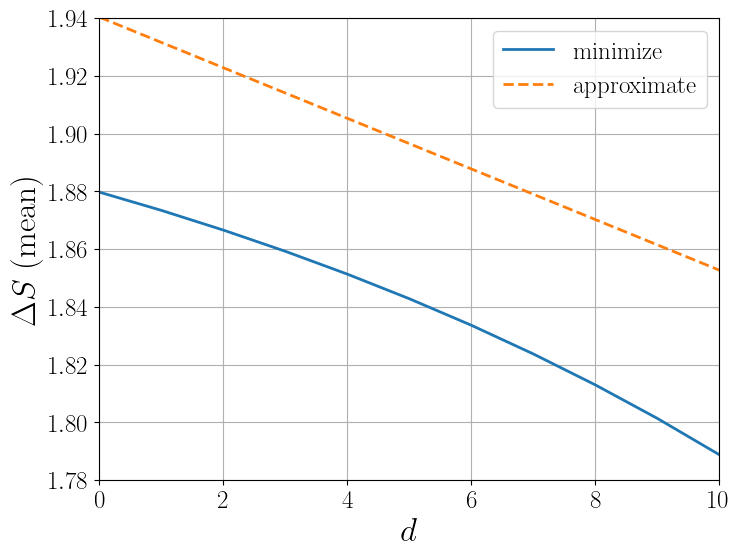

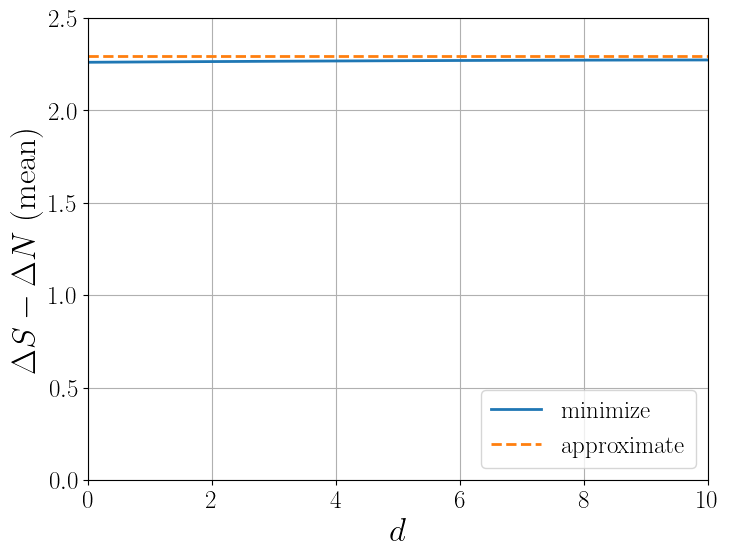

In [48]:
guitar_name = 'Classical Guitar'
scale_length = 650.0
b = 1.0
c = 4.0

string_count = 6
max_fret = 12

path_guitar_strings_specs = gitpath + '/data/guitar_strings_specs.xlsx'
path_guitar_strings_props = gitpath + '/data/guitar_strings_props.xlsx'

strings_name = "D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)"
sheet_name = 'EJ45'

strings = cg.GuitarStrings(strings_name, path_guitar_strings_specs, path_guitar_strings_props,
                           sheet_name=sheet_name, scale_length=scale_length)

params = { 'name' : guitar_name + ' + ' + sheet_name,
           'x0' : scale_length,
           'b' : b,
           'c' : c,
           'd' : 0,
           'ds' : 0,
           'dn' : 0}
guitar = cg.Guitar(params, string_count, strings)

dsdx_all = np.zeros(string_count)
dndx_all = np.zeros(string_count)
dsd_all = np.zeros(string_count)
dnd_all = np.zeros(string_count)

d_list = np.linspace(0,10,num=11,endpoint=True)
for d in d_list:
    guitar.set_params({'d' : d, 'ds' : 0, 'dn' : 0})
    dsx, dnx = guitar.approximate()
    ds, dn = guitar.minimize(max_fret)
    dsdx_all = np.vstack((dsdx_all, dsx))
    dndx_all = np.vstack((dndx_all, dnx))
    dsd_all = np.vstack((dsd_all, ds))
    dnd_all = np.vstack((dnd_all, dn))
dsdx_mean = np.mean(dsdx_all[1:], axis=1)
dndx_mean = np.mean(dndx_all[1:], axis=1)
dsd_mean = np.mean(dsd_all[1:], axis=1)
dnd_mean = np.mean(dnd_all[1:], axis=1)

plt.figure(figsize=(8.0,6.0))
plt.plot(d_list, dsd_mean, linewidth=linewidth, label='minimize')
plt.plot(d_list, dsdx_mean, '--', linewidth=linewidth, label='approximate')
plt.xlabel(r'$d$', fontdict=font)
plt.ylabel(r'$\Delta S$ (mean)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(d_list[0],d_list[-1])
plt.ylim(1.78,1.94)
plt.grid(True)
plt.legend(loc='upper right', fontsize=labelsize)
plt.show()

plt.figure(figsize=(8.0,6.0))
plt.plot(d_list, -dnd_mean, linewidth=linewidth, label='minimize')
plt.plot(d_list, -dndx_mean, '--', linewidth=linewidth, label='approximate')
plt.xlabel(r'$d$', fontdict=font)
plt.ylabel(r'$-\Delta N$ (mean)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(d_list[0],d_list[-1])
plt.ylim(0.34,0.50)
plt.grid(True)
plt.legend(loc='upper left', fontsize=labelsize)
plt.show()

kappa = np.mean(strings.get_props().kappa.to_numpy())
b_0 = np.mean(strings.get_props().b_0.to_numpy())
dsmdnx = (b_0 * scale_length + kappa * (2*b + c)**2/(4 * scale_length)) * np.ones_like(dsd_mean)

plt.figure(figsize=(8.0,6.0))
plt.plot(d_list, dsd_mean - dnd_mean, linewidth=linewidth, label='minimize')
plt.plot(d_list, dsmdnx, '--', linewidth=linewidth, label='approximate')
plt.xlabel(r'$d$', fontdict=font)
plt.ylabel(r'$\Delta S -\Delta N$ (mean)', fontdict=font)
plt.tick_params(axis='x', labelsize=labelsize)
plt.tick_params(axis='y', labelsize=labelsize)
plt.xlim(d_list[0],d_list[-1])
plt.ylim(2.30,2.32)
plt.ylim(0.0,2.5)
plt.grid(True)
plt.legend(loc='lower right', fontsize=labelsize)
plt.show()

## String Volume Densities (mg/mm$^3$)

In [50]:
path_guitar_strings_specs = gitpath + '/data/guitar_strings_specs.xlsx'
path_guitar_strings_props = gitpath + '/data/guitar_strings_props.xlsx'

strings_names = [ "D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)",
                  "D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)",
                  "D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)"
                ]
sheet_names = [ 'EJ43', 'EJ45', 'EJ46', 'EJ44', 'EJ45FF', 'EJ46FF' ]

density_all = np.zeros(string_count)

for strings_name, sheet_name in zip(strings_names, sheet_names):
    print('[magenta]' + strings_name + '[/magenta]')    
    strings = cg.GuitarStrings(strings_name,
                               path_guitar_strings_specs, path_guitar_strings_props,
                               scale_length=scale_length, sheet_name=sheet_name)
    rho = strings.get_specs().radius.to_numpy()
    mu = strings.get_specs().density.to_numpy()
    volume_density = mu / (np.pi * rho**2)
    
    density_all = np.vstack((density_all, volume_density))

print(density_all[1:])
print( 100 * (density_all[1] - density_all[2]) / density_all[2] )

D'Addario Pro-Arte Nylon Classical Guitar Strings - Light Tension (EJ43)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Normal Tension (EJ45)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Hard Tension (EJ46)

D'Addario Pro-Arte Nylon Classical Guitar Strings - Extra Hard Tension (EJ44)

D'Addario Pro-Arte Carbon Classical Guitar Strings - Normal Tension (EJ45FF)

D'Addario Pro-Arte Carbon Classical Guitar Strings - Hard Tension (EJ46FF)

[[0.94323483 0.9571053  1.01184101 4.58655423 4.96672738 5.77016663]
 [0.94041669 0.96092341 1.01535442 4.50659723 5.29826806 5.83865954]
 [0.93764784 0.96373265 1.00529983 4.40030298 5.30849936 5.77543468]
 [0.939957   0.96809091 1.01601835 4.40030298 5.30849936 5.9784564 ]
 [1.5908366  1.61963002 1.60838023 4.13567568 4.97719577 5.82531393]
 [1.60446179 1.61830787 1.62536604 4.3163429  5.41156382 5.71285454]]

[ 0.29966974 -0.39733788 -0.34602716  1.77422117 -6.25752929 -1.17309296]